In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from datetime import date
from sklearn.preprocessing import LabelEncoder
import dataframe_image as dfi
import datetime
from datetime import date
plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'

# Data preparation and basic dataset properties

In [2]:
df = pd.read_table("./processed/covid_data_with_levels_anonimized.csv", sep=',' , index_col=0)
print(df.shape)

(110781, 15)


In [3]:
def necessary_implementation_df(df):
    '''Standarization procedures needed to put data in correct format, dropping empty instances (rows)
     and sorting values by MDN and Date of annotations'''

    #by doing this aprox 40k instances are deleted, meaning they don't have any domain assigned. 
    df = df.dropna(axis = 0, how='all', subset=['ADM_lvl','ATT_lvl','BER_lvl','ENR_lvl','ETN_lvl', 'FAC_lvl','INS_lvl','MBW_lvl','STM_lvl']) 
    print(df.shape)

    #selection of unique IDs
    unique_id = df['MDN'].unique()
    df['MDN'].nunique() #1290 unique ids
    df.head()
    df = df.sort_values(by=["MDN", "Notitiedatum"]) #to order by MDN and date hierarchically
    
    return df

df = necessary_implementation_df(df)

(71287, 15)


In [4]:
def filtered_unique_id(df):
    '''Creates filtered dataframes with minimum number of notes per patients being 50, 100 and 500.
    Table with uniqueID, annotated, not annoated, total notes is created'''
    
    df_filtered50 =df.groupby(['MDN']).filter(lambda x: len(x) > 50)
    df_filtered100 =df.groupby(['MDN']).filter(lambda x: len(x) > 100)
    df_filtered100.nunique()

    df_filtered500 =df.groupby(['MDN']).filter(lambda x: len(x) > 500)
    df_filtered500['MDN'].nunique()

    data = [{'uniqueID':df_filtered50['MDN'].nunique(), 'annotated': df_filtered50.annotated.value_counts()[1], 'not annoated': df_filtered50.annotated.value_counts()[0], 'total notes':df_filtered50.shape[0]},
            {'uniqueID':df_filtered100['MDN'].nunique(), 'annotated': df_filtered100.annotated.value_counts()[1], 'not annoated': df_filtered100.annotated.value_counts()[0], 'total notes':df_filtered100.shape[0]},
            {'uniqueID':df_filtered500['MDN'].nunique(), 'annotated': df_filtered500.annotated.value_counts()[1], 'not annoated': df_filtered500.annotated.value_counts()[0], 'total notes':df_filtered500.shape[0]}]
    
    # Creates DataFrame.
    df_summary = pd.DataFrame(data, index =['>50 per ID','>100 per ID', '>500 per ID'])
    dfi.export(df_summary,"./figures/summary_unID.png")
    return df_summary

df_summary = filtered_unique_id(df)
display(df_summary)

uniqueID  annotated  not annoated  total notes
>50 per ID        443       1504         50429        51933
>100 per ID       192       1018         33382        34400
>500 per ID         2         41          1064         1105

AxesSubplot(0.125,0.125;0.775x0.755)


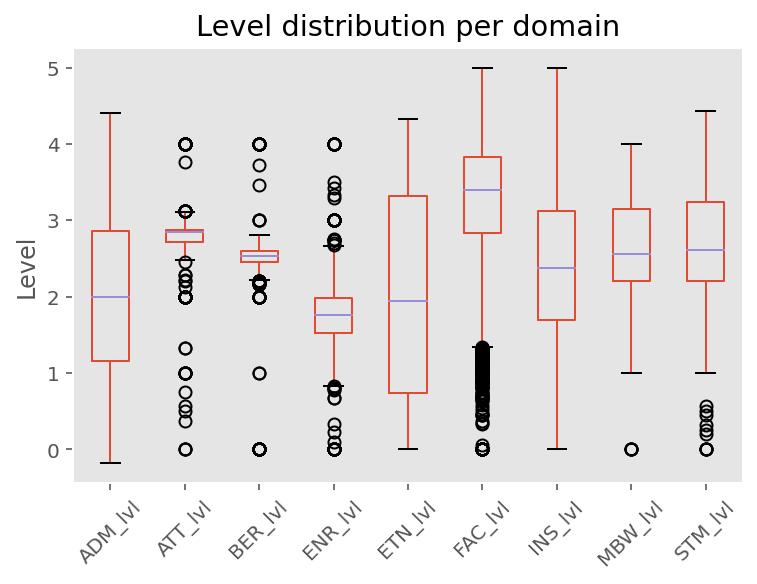

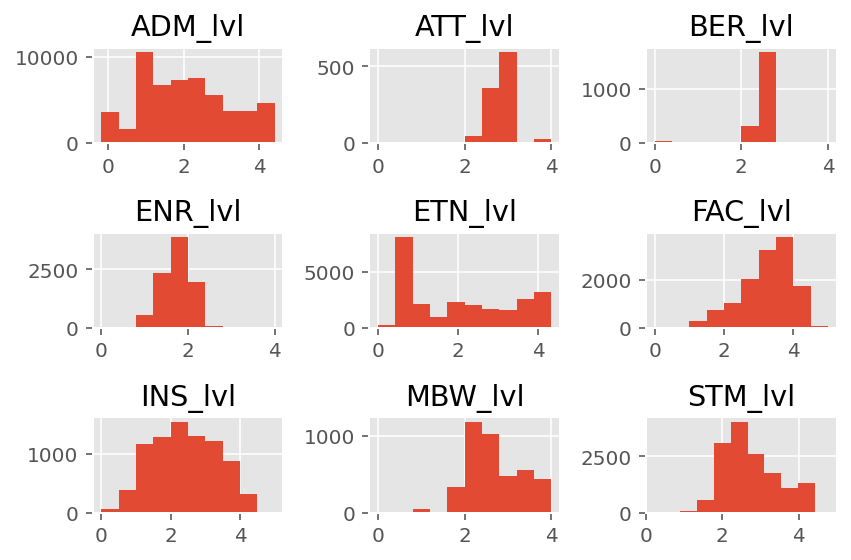

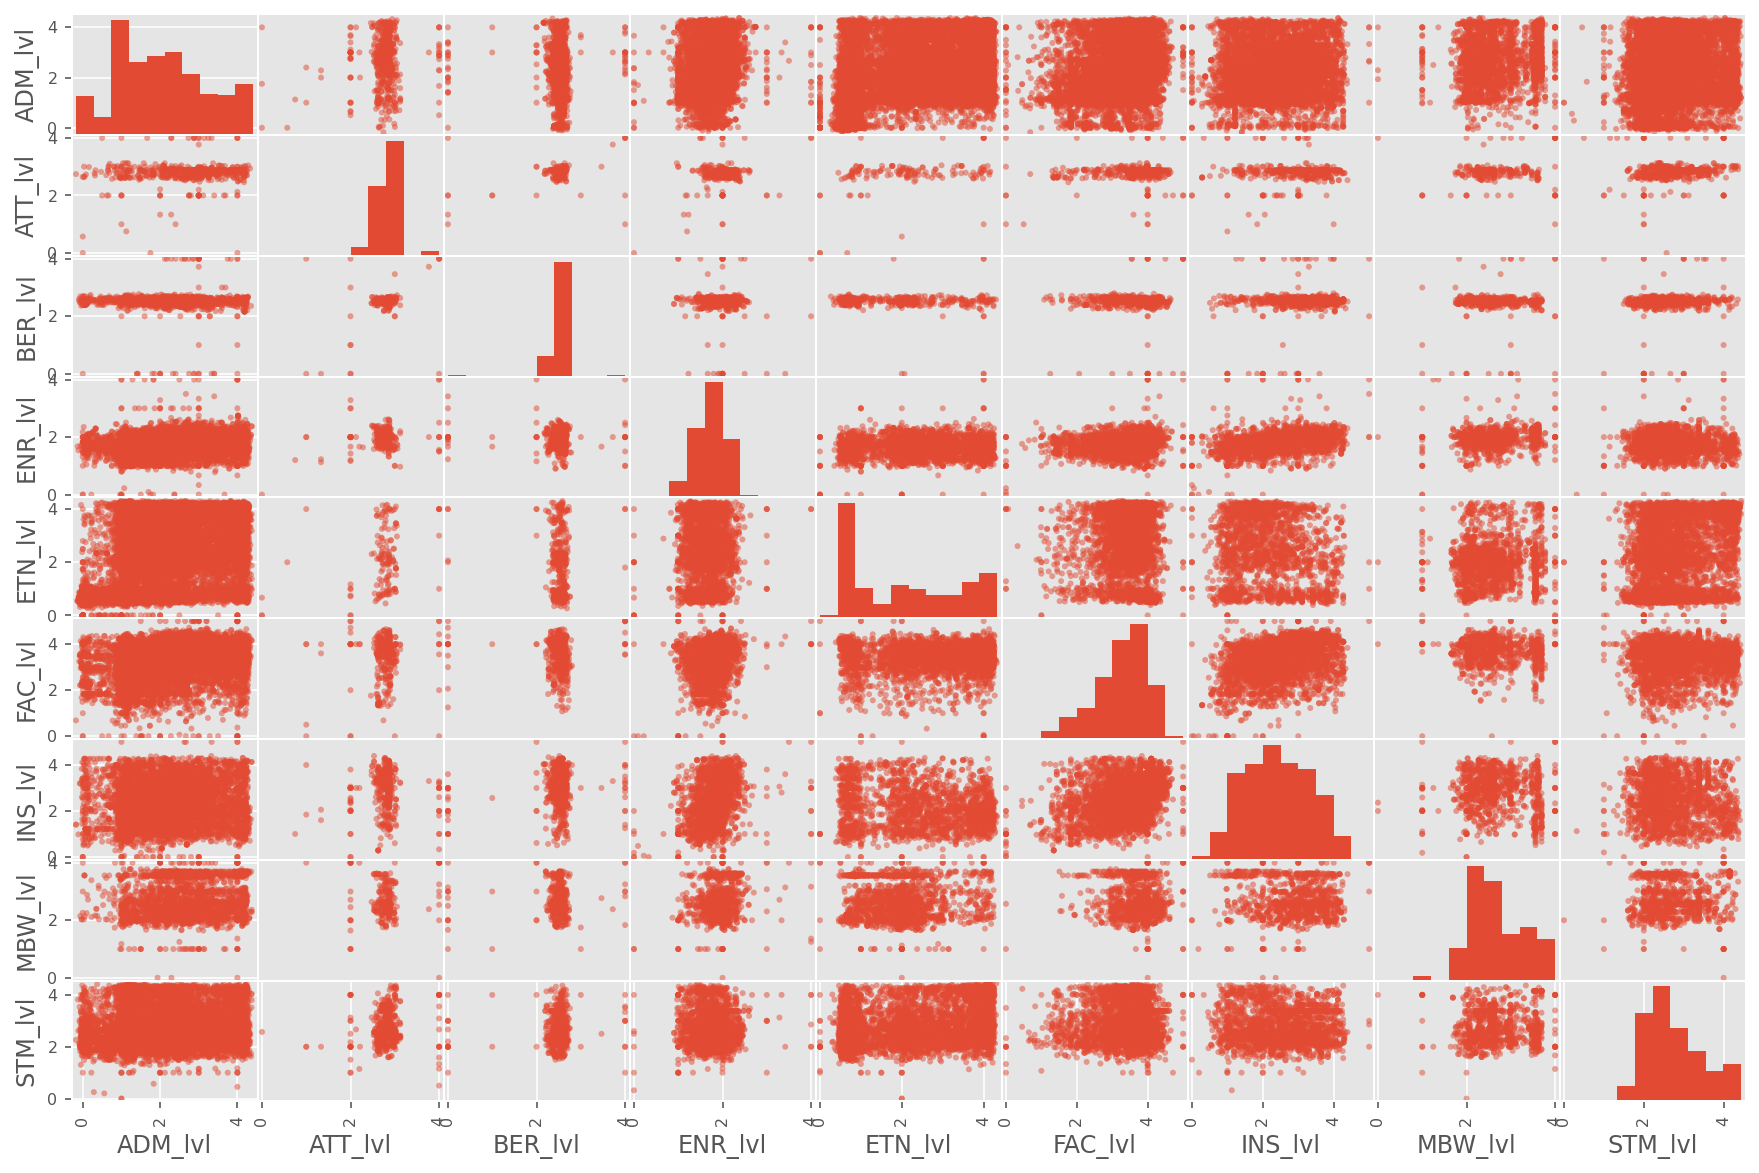

In [5]:
columns = ['ADM_lvl','ATT_lvl','BER_lvl','ENR_lvl','ETN_lvl', 'FAC_lvl','INS_lvl','MBW_lvl','STM_lvl']

def lev_distribution(df):
    '''Creates boxplot, histogram and scatterplot with level distribution for a given dataframe.
    Saves plots within figures folder.'''

    #distribution of levels per domain for the filtered dataset
    lev_dom_boxplot = df.boxplot(column = columns, grid=False, rot=45, fontsize=10)
    plt.gca().set(title='Level distribution per domain', ylabel='Level')
    print(lev_dom_boxplot)
    plt.savefig('./figures/level_domain_boxplot.png', dpi=300)

    hist = df[columns].hist() #fac and ins have 5 levels, all other domains have 4
    plt.xlim(0,5)
    plt.tight_layout()
    plt.savefig('./figures/level_domain_histogram.png', dpi=300)

    scatter = pd.plotting.scatter_matrix(df[columns], figsize=(15,10))
    plt.savefig('./figures/scatter_paiwise_domain.png', dpi=300)
    
    return lev_dom_boxplot, hist, scatter

lev_distribution(df)
plt.show()

### Aligning time

In [6]:
def align_time(df):
    '''Align first day of notes per patient as being day 0, and calculates all consecutive days from that.'''
    
    df['year'] = df['Notitiedatum'].str.split('-').str[0]
    df['month'] = df['Notitiedatum'].str.split('-').str[1]
    df['day'] = df['Notitiedatum'].str.split('-').str[2]

    #array with idx for first occurrence of a patient (trick from https://stackoverflow.com/questions/41255215/pandas-find-first-occurrence)
    first_occ= [df.MDN.eq(patient).idxmax() for patient in df.MDN.unique()]

    deltas = []
    counter = 0
    for idx in first_occ: 
        f_date = date(int(df['year'][idx]), int(df['month'][idx]), int(df['day'][idx])) #reference date (first visit)
        df_patient = df[df.MDN ==df.MDN[idx]]
        counter +=  len(df_patient)
        for year,month,day in zip(df_patient['year'],df_patient['month'],df_patient['day']): #smaller dataframe with only a given patient data
            l_date = date(int(year), int(month), int(day)) #put i to generalize
            deltas.append(str(l_date-f_date).split(" ")[0].split(":")[0])
            if int(str(l_date-f_date).split(" ")[0].split(":")[0]) > 460: 
                print(str(l_date-f_date).split(" ")[0].split(":")[0])
                print(year, month, day)
    df['Days_count'] = deltas
    print(len(deltas),len(df['Notitiedatum']),counter)

    #encode days_count as int64
    labelenc = LabelEncoder()
    df.iloc[:,-1] = labelenc.fit_transform(df.iloc[:,-1].values)
    
    return df 

df = align_time(df)      

71287 71287 71287


initial data vs trimmed in number of patients: 1289 | 1289
max days difference between note and previous note: 428.0 | 2.0
n unique days count: 386
min days count: 0
mean days count: 198.8082729416625
max days count: 429


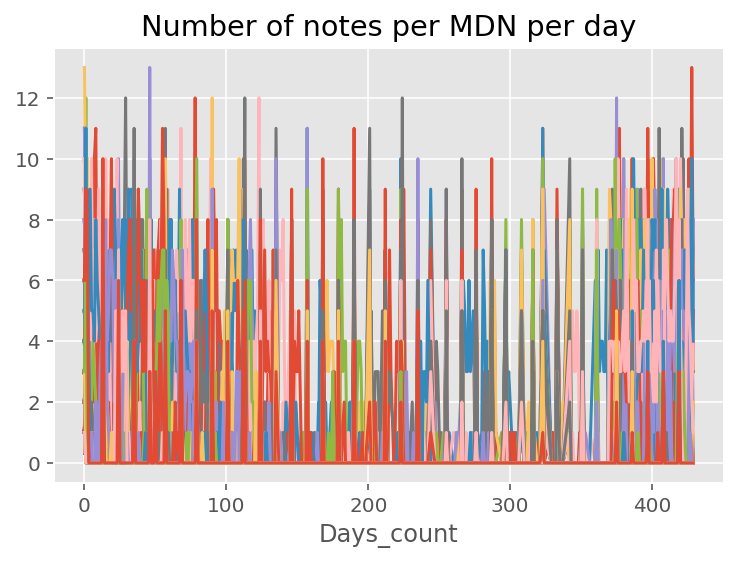

In [7]:
def gen_info_data(df):
    '''General information of given dataset (mean, max, min days count) and compares to the raw dataset(unfiltered).'''

    #difference between day of note and previous date of note. for first note of patient this value is defined as zero.
    df['Dif'] = df.Days_count.diff(periods=1)
    df['Dif'] = df['Dif'].clip(lower=0, upper=None, axis=0)

    #check how many days without any note indicates the person is not anymore admitted. My initial filter is if it is 14 days in a row without notes, notes after are disregarded
    df_trim = df[df['Dif'] < 3]
    # print('changes in dataframe shape when no initial filter and consider discharge in the third day without annotations: ' + str(df.shape)+ str(df_trim.shape))

    print('initial data vs trimmed in number of patients: ' + str(df['MDN'].nunique()) + ' | ' + str(df_trim['MDN'].nunique()))

    #max days difference between note and previous note:
    print('max days difference between note and previous note: ' + str(df['Dif'].max()) + ' | '+ str(df_trim['Dif'].max()))

    print('n unique days count: ' + str(df_trim['Days_count'].nunique()) +
    '\nmin days count: ' + str(df_trim['Days_count'].min()) +
    '\nmean days count: ' + str(df_trim['Days_count'].mean()) +
    '\nmax days count: ' + str(df_trim['Days_count'].max()))

    MDN_per_day = pd.crosstab(df_trim['Days_count'], df_trim['MDN']).plot(legend=False, title='Number of notes per MDN per day')
    plt.savefig('./figures/MDN_per_day.png', dpi=300)
    
    return df, df_trim, MDN_per_day

df, df_trim, MDN_per_day = gen_info_data(df)


# Graphic Results:

## Creating tables and plots

### Within admission period

In [8]:
def trim_and_statistics_all_groups(df,trim, day):
    '''Creates summary statistics (mean, min, max, median) of levels per domain from a given dataframe.
    Input: dataframe, 
    trim (number of days without notes that assumes the patient was discharged), 
    day (day in which you want to create statistics)'''
    
    df_trim = df[df['Dif'] < trim]
    hosp_day = df_trim[df_trim['Days_count']== day]
    columns = ['ADM_lvl','ATT_lvl','BER_lvl','ENR_lvl','ETN_lvl' ,'FAC_lvl','INS_lvl','MBW_lvl','STM_lvl']

    keys_mean = ['ADM_ad','ATT_ad','BER_ad','ENR_ad','ETN_ad' ,'FAC_ad','INS_ad','MBW_ad','STM_ad']
    dict_mean = dict(zip(keys_mean, [hosp_day[col].mean(skipna=True) for col in columns]))

    keys_min = ['ADM_ad_min','ATT_ad_min','BER_ad_min','ENR_ad_min','ETN_ad_min' ,'FAC_ad_min','INS_ad_min','MBW_ad_min','STM_ad_min']
    dict_min = dict(zip(keys_min, [hosp_day[col].min(skipna=True) for col in columns]))

    keys_max = ['ADM_ad_max','ATT_ad_max','BER_ad_max','ENR_ad_max','ETN_ad_max' ,'FAC_ad_max','INS_ad_max','MBW_ad_max','STM_ad_max']
    dict_max = dict(zip(keys_max, [hosp_day[col].max(skipna=True) for col in columns]))

    keys_median = ['ADM_ad_med','ATT_ad_med','BER_ad_med','ENR_ad_med','ETN_ad_med' ,'FAC_ad_med','INS_ad_med','MBW_ad_med','STM_ad_med']
    dict_median = dict(zip(keys_median, [hosp_day[col].median(skipna=True) for col in columns]))
    
    data = [
    {'mean':dict_mean['ADM_ad'],'min': dict_min['ADM_ad_min'], 'max': dict_max['ADM_ad_max'], 'median': dict_median['ADM_ad_med'],'count':len(hosp_day['ADM_lvl']) - hosp_day['ADM_lvl'].isnull().sum(axis = 0)},
    {'mean':dict_mean['ATT_ad'],'min': dict_min['ATT_ad_min'], 'max': dict_max['ATT_ad_max'], 'median': dict_median['ATT_ad_med'],'count':len(hosp_day['ATT_lvl']) - hosp_day['ATT_lvl'].isnull().sum(axis = 0)},
    {'mean':dict_mean['BER_ad'],'min': dict_min['BER_ad_min'], 'max': dict_max['BER_ad_max'], 'median': dict_median['BER_ad_med'],'count':len(hosp_day['BER_lvl']) - hosp_day['BER_lvl'].isnull().sum(axis = 0)},
    {'mean':dict_mean['ENR_ad'],'min': dict_min['ENR_ad_min'], 'max': dict_max['ENR_ad_max'], 'median': dict_median['ENR_ad_med'],'count':len(hosp_day['ENR_lvl']) - hosp_day['ENR_lvl'].isnull().sum(axis = 0)},
    {'mean':dict_mean['ETN_ad'],'min': dict_min['ETN_ad_min'], 'max': dict_max['ETN_ad_max'], 'median': dict_median['ETN_ad_med'],'count':len(hosp_day['ETN_lvl']) - hosp_day['ETN_lvl'].isnull().sum(axis = 0)},
    {'mean':dict_mean['FAC_ad'],'min': dict_min['FAC_ad_min'], 'max': dict_max['FAC_ad_max'], 'median': dict_median['FAC_ad_med'],'count':len(hosp_day['FAC_lvl']) - hosp_day['FAC_lvl'].isnull().sum(axis = 0)},
    {'mean':dict_mean['INS_ad'],'min': dict_min['INS_ad_min'], 'max': dict_max['INS_ad_max'], 'median': dict_median['INS_ad_med'],'count':len(hosp_day['INS_lvl']) - hosp_day['INS_lvl'].isnull().sum(axis = 0)},
    {'mean':dict_mean['MBW_ad'],'min': dict_min['MBW_ad_min'], 'max': dict_max['MBW_ad_max'], 'median': dict_median['MBW_ad_med'],'count':len(hosp_day['MBW_lvl']) - hosp_day['MBW_lvl'].isnull().sum(axis = 0)},
    {'mean':dict_mean['STM_ad'],'min': dict_min['STM_ad_min'], 'max': dict_max['STM_ad_max'], 'median': dict_median['STM_ad_med'],'count':len(hosp_day['STM_lvl']) - hosp_day['STM_lvl'].isnull().sum(axis = 0)}]
            
    # Creates DataFrame.
    df_summary = pd.DataFrame(data, index = columns)
    return df_summary.round(decimals=2), df_trim

In [9]:
#table with all statistics for a particular day

df_0, tr0 = trim_and_statistics_all_groups(df, 3, 0)
df_1, tr1 = trim_and_statistics_all_groups(df, 3, 1)
df_2, tr2 = trim_and_statistics_all_groups(df, 3, 2)
df_3, tr3 = trim_and_statistics_all_groups(df, 3, 3)
df_4, tr4 = trim_and_statistics_all_groups(df, 3, 4)
df_5, tr5 = trim_and_statistics_all_groups(df, 3, 5)
df_6, tr6 = trim_and_statistics_all_groups(df, 3, 6)
df_7, tr7 = trim_and_statistics_all_groups(df, 3, 7)

dfi.export(df_0,"./figures/stat_day0.png")

#example of result
df_0


mean   min   max  median  count
ADM_lvl  2.31 -0.08  4.38    2.27   3454
ATT_lvl  2.79  0.00  4.00    2.80     37
BER_lvl  2.53  2.19  4.00    2.54    201
ENR_lvl  1.82  0.00  3.00    1.87    659
ETN_lvl  2.36  0.00  4.24    2.33    951
FAC_lvl  3.70  0.00  5.00    3.77    582
INS_lvl  2.83  0.00  4.29    2.86    445
MBW_lvl  2.59  1.00  4.00    2.43    277
STM_lvl  2.59  1.00  4.33    2.48    495

In [10]:
def compare_mean_med(df0, df1, df2):
    '''Creates 2 tables, one for mean and one for median comparing 3 different dates/ranges of dates per domain'''
    
    df0 = df0.rename(columns ={"mean": "mean0", "min": "min0","max": "max0", "median": "median0","count": "count0"})
    df1 = df1.rename(columns ={"mean": "mean1", "min": "min1","max": "max1", "median": "median1","count": "count1"})
    df2 = df2.rename(columns ={"mean": "mean2", "min": "min2","max": "max2", "median": "median2","count": "count2"})
    
    df_mean = pd.concat([df0.iloc[:,0], df1.iloc[:,0], df2.iloc[:,0],df0.iloc[:,-1], df1.iloc[:,-1], df2.iloc[:,-1]], axis=1)
    df_mean.insert(3, 'delta 1-0', df1.iloc[:,0] - df0.iloc[:,0])
    df_mean.insert(4, 'delta 2-0', df2.iloc[:,0] - df0.iloc[:,0])
    
    df_median = pd.concat([df0.iloc[:,3], df1.iloc[:,3], df2.iloc[:,3],df0.iloc[:,-1], df1.iloc[:,-1], df2.iloc[:,-1]], axis=1)
    df_median.insert(3, 'delta 1-0', df1.iloc[:,3] - df0.iloc[:,3])
    df_median.insert(4, 'delta 2-0', df2.iloc[:,3] - df0.iloc[:,3])
    
    dfi.export(df_mean,"./figures/compare_mean.png")
    dfi.export(df_median,"./figures/compare_med.png")
    return df_mean, df_median

In [11]:
mean, med = compare_mean_med(df_0, df_4, df_7)
display(mean, med)

mean0  mean1  mean2  delta 1-0  delta 2-0  count0  count1  count2
ADM_lvl   2.31   2.44   2.58       0.13       0.27    3454      99      77
ATT_lvl   2.79   2.83   3.26       0.04       0.47      37       3       3
BER_lvl   2.53   2.41   2.70      -0.12       0.17     201       2       4
ENR_lvl   1.82   1.75   1.95      -0.07       0.13     659      14      13
ETN_lvl   2.36   2.31   2.41      -0.05       0.05     951      39      38
FAC_lvl   3.70   3.25   3.18      -0.45      -0.52     582      19      17
INS_lvl   2.83   2.35   2.17      -0.48      -0.66     445      12      21
MBW_lvl   2.59   2.59   2.97       0.00       0.38     277      11       9
STM_lvl   2.59   2.42   2.84      -0.17       0.25     495      36      30

median0  median1  median2  delta 1-0  delta 2-0  count0  count1  \
ADM_lvl     2.27     2.36     2.49       0.09       0.22    3454      99   
ATT_lvl     2.80     2.88     2.90       0.08       0.10      37       3   
BER_lvl     2.54     2.41     2.40      -0.13      -0.14     201       2   
ENR_lvl     1.87     1.72     1.91      -0.15       0.04     659      14   
ETN_lvl     2.33     2.21     2.48      -0.12       0.15     951      39   
FAC_lvl     3.77     3.39     3.52      -0.38      -0.25     582      19   
INS_lvl     2.86     2.01     2.00      -0.85      -0.86     445      12   
MBW_lvl     2.43     2.62     3.00       0.19       0.57     277      11   
STM_lvl     2.48     2.19     2.68      -0.29       0.20     495      36   

         count2  
ADM_lvl      77  
ATT_lvl       3  
BER_lvl       4  
ENR_lvl      13  
ETN_lvl      38  
FAC_lvl      17  
INS_lvl      21  
MBW_lvl       9  
STM_lvl      30

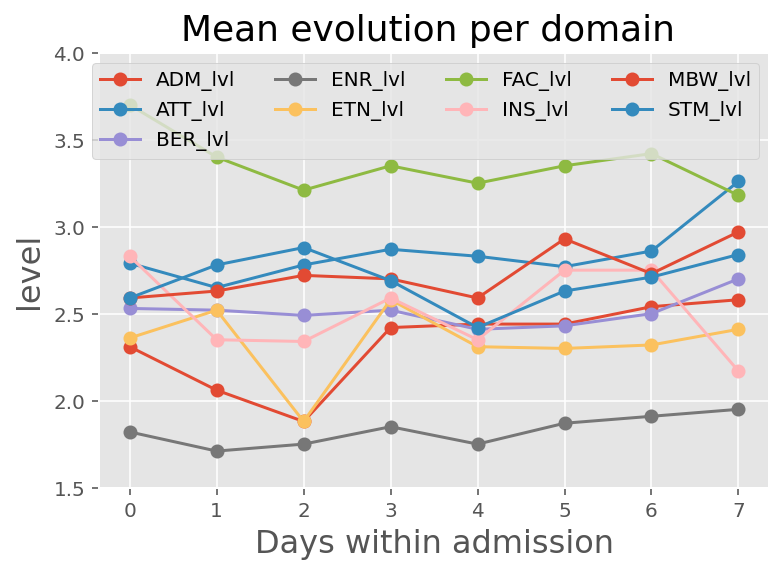

In [12]:
#creates dataframe with daily mean per domain for the seven first days 
seven_days_mean = pd.concat([df_0.iloc[:,0],df_1.iloc[:,0],df_2.iloc[:,0],df_3.iloc[:,0],df_4.iloc[:,0],df_5.iloc[:,0],df_6.iloc[:,0],df_7.iloc[:,0]], axis=1)
seven_days_mean = pd.DataFrame.transpose(seven_days_mean)
seven_days_mean = seven_days_mean.set_axis([0,1,2,3,4,5,6,7], axis='index')

#creates table of counts per domain for the seven first days 
seven_days_count = pd.concat([df_0.iloc[:,-1],df_1.iloc[:,-1],df_2.iloc[:,-1],df_3.iloc[:,-1],df_4.iloc[:,-1],df_5.iloc[:,-1],df_6.iloc[:,-1],df_7.iloc[:,-1]], axis=1)
seven_days_count['sum'] = seven_days_count.sum(axis=1)
seven_days_count
dfi.export(seven_days_count,"./figures/seven_days_count.png")

#plots mean evolution per domain for the seven days within admission
plt.plot(seven_days_mean,'o-')
plt.title("Mean evolution per domain ",fontsize=18)
plt.xlabel("Days within admission",fontsize=16)
plt.ylabel("level",fontsize=16)
plt.ylim(1.5, 4)
plt.legend(columns,ncol=4)
plt.tick_params(axis='both', labelsize= 10)
plt.savefig('./figures/mean_ev_7d_each_domain_plot.png', dpi=300)


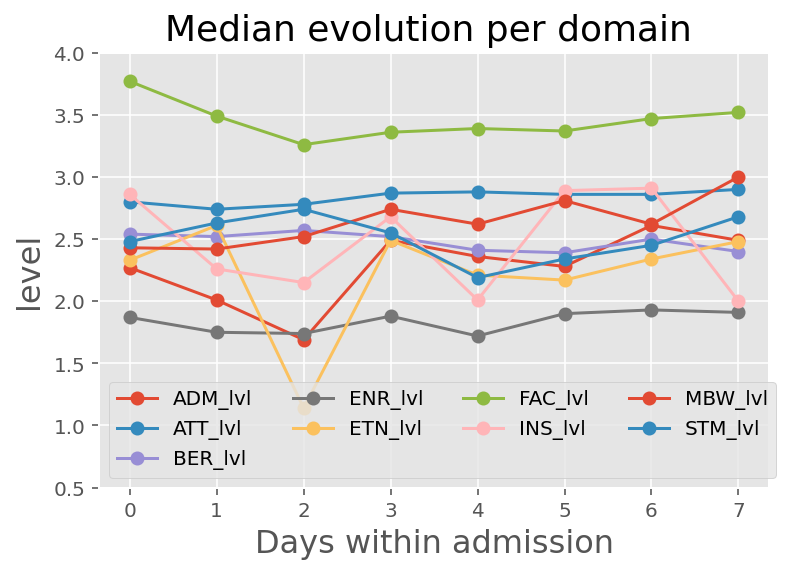

In [13]:
#creates dataframe with daily median per domain for the seven first days 
seven_days_med = pd.concat([df_0.iloc[:,3],df_1.iloc[:,3],df_2.iloc[:,3],df_3.iloc[:,3],df_4.iloc[:,3],df_5.iloc[:,3],df_6.iloc[:,3],df_7.iloc[:,3]], axis=1)
seven_days_med = pd.DataFrame.transpose(seven_days_med)
seven_days_med = seven_days_med.set_axis([0,1,2,3,4,5,6,7], axis='index')

#plots median evolution per domain for the seven days within admission
plt.plot(seven_days_med,'o-')
plt.title("Median evolution per domain ",fontsize=18)
plt.xlabel("Days within admission",fontsize=16)
plt.ylabel("level",fontsize=16)
plt.ylim(0.5, 4)
plt.legend(columns,ncol=4)
plt.tick_params(axis='both', labelsize= 10)
plt.savefig('./figures/med_ev_7d_each_domain_plot.png', dpi=300)

AxesSubplot(0.125,0.125;0.775x0.755)


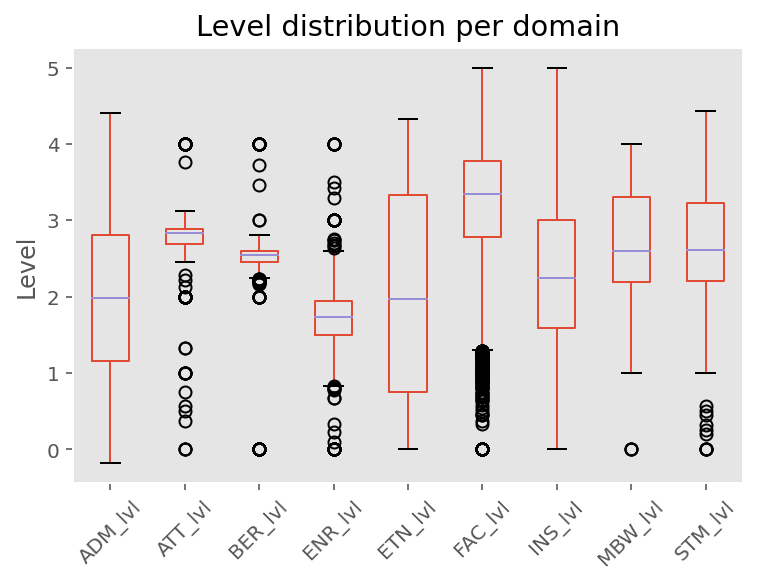

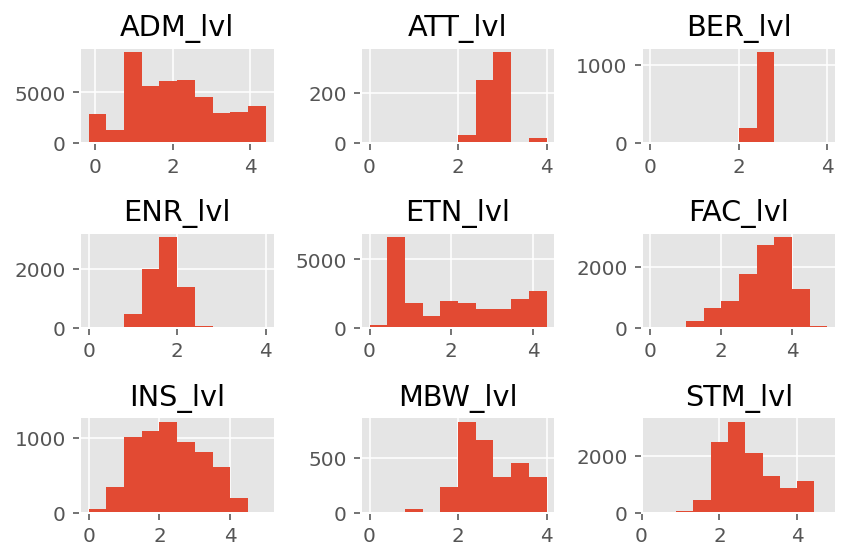

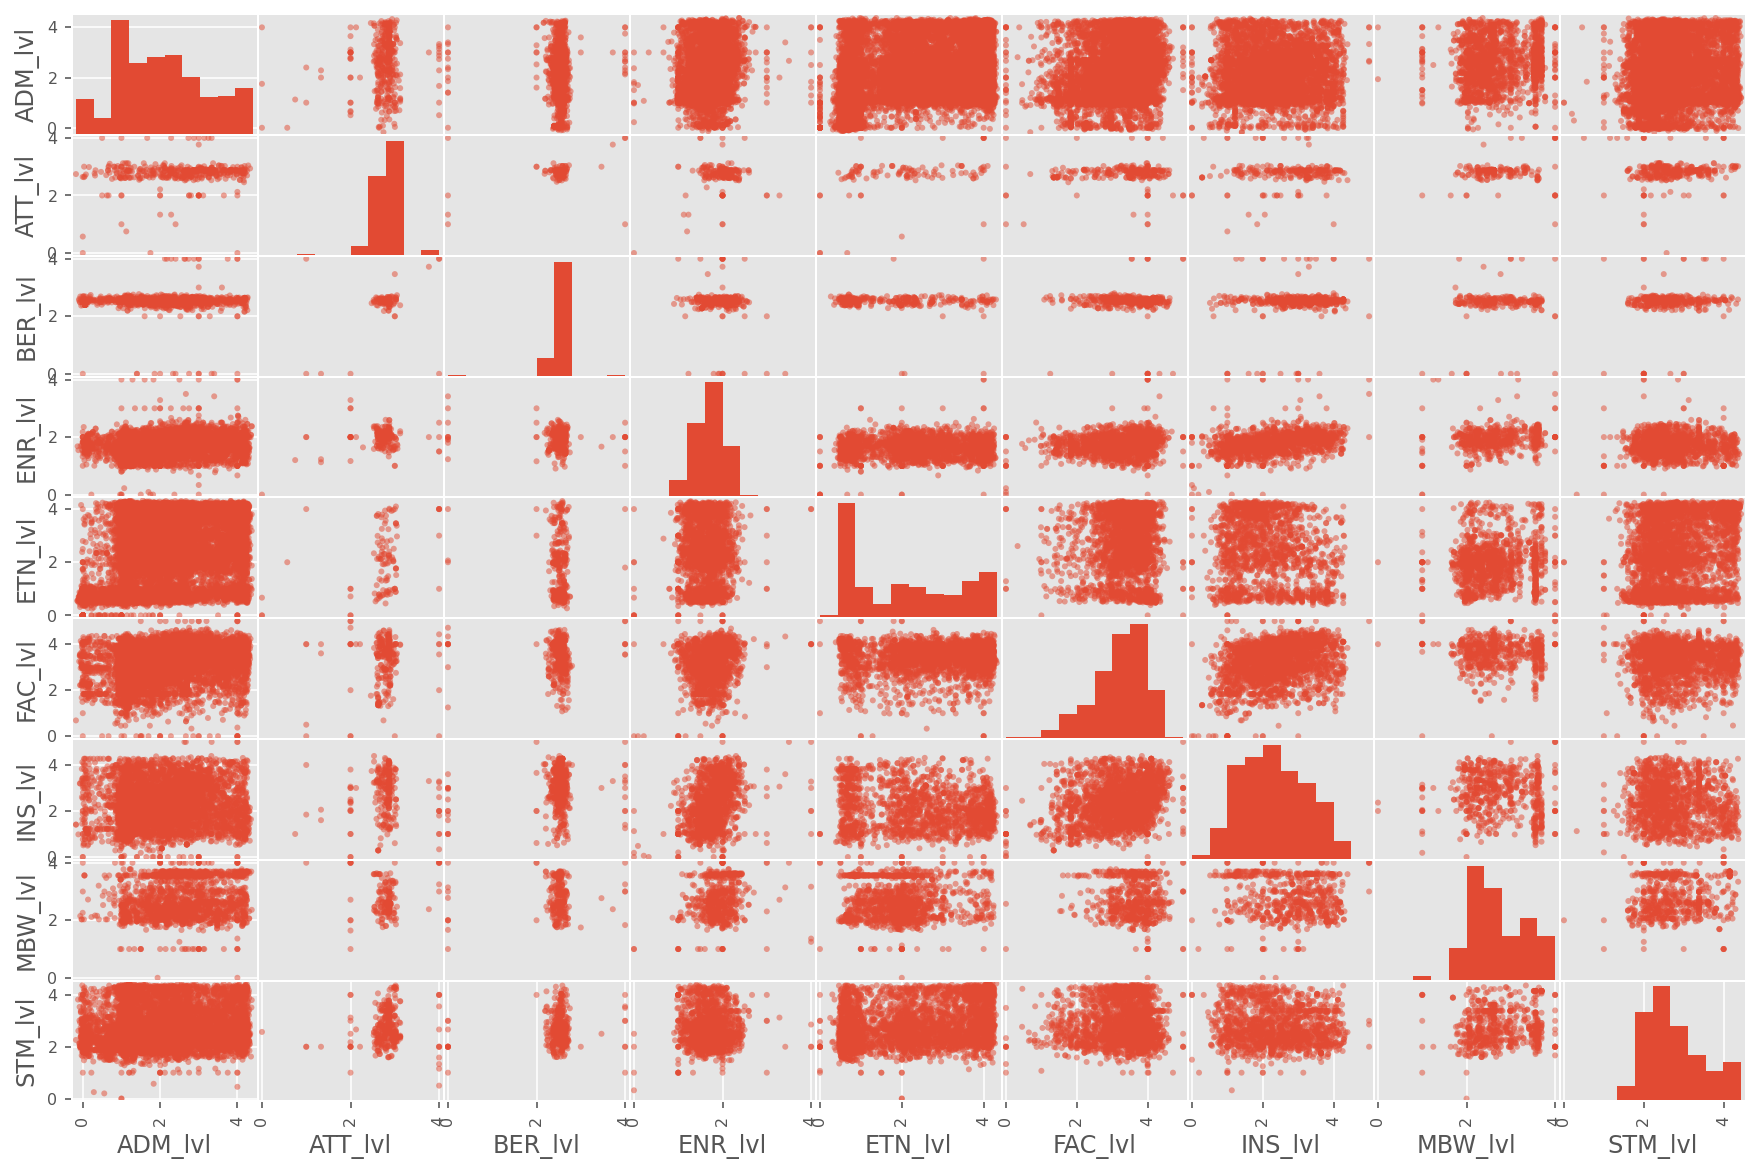

In [14]:
#distribution within admission period 
lev_distribution(df_trim)
plt.show()

### After discharge

In [15]:
def discharge_data(df):
    '''Aligns discharge day to day 0 for each patient, creating a new column on the dataframe.'''
    
    df['year'] = df['Notitiedatum'].str.split('-').str[0]
    df['month'] = df['Notitiedatum'].str.split('-').str[1]
    df['day'] = df['Notitiedatum'].str.split('-').str[2]

    discharge = df[df['Dif'] >= 3]

    #array with idx for first occurrence of a patient (trick from https://stackoverflow.com/questions/41255215/pandas-find-first-occurrence)
    first_occ_disc= [discharge.MDN.eq(patient).idxmax() for patient in discharge.MDN.unique()]

    disc = []
    counter = 0
    for idx in first_occ_disc: 
        f_date = date(int(discharge['year'][idx]), int(discharge['month'][idx]), int(discharge['day'][idx])) #reference date (first visit)
        df_patient = discharge[discharge.MDN ==discharge.MDN[idx]]
        counter +=  len(df_patient)
        for year,month,day in zip(df_patient['year'],df_patient['month'],df_patient['day']): #smaller dataframe with only a given patient data
            l_date = date(int(year), int(month), int(day)) #put i to generalize
            disc.append(str(l_date-f_date).split(" ")[0].split(":")[0])
    discharge['Days_count_from_discharge'] = disc
    print(len(disc),len(discharge['Notitiedatum']),counter)       
    
    #encode days_count as int64
    labelenc = LabelEncoder()
    discharge.iloc[:,-1] = labelenc.fit_transform(discharge.iloc[:,-1].values)

    return discharge

discharge = discharge_data(df)

13193 13193 13193


<ipython-input-15-f69be587f6a0>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  discharge['Days_count_from_discharge'] = disc
/Users/brunaguedes/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [16]:
def trim_and_statistics_all_groups_discharge(discharge_df, day1, day2):
    '''Creates summary statistics (mean, min, max, median) of levels per domain from a discharge dataframe.
    Input: dataframe,  
    day1 (begininh day from which you want to create statistics)
    day2 (last day (exclusive) from which you want to create statistics)'''

    hosp_day = discharge_df.loc[(discharge_df['Days_count_from_discharge'] >= day1) & 
                         (discharge_df['Days_count_from_discharge'] < day2)]

    columns = ['ADM_lvl','ATT_lvl','BER_lvl','ENR_lvl','ETN_lvl' ,'FAC_lvl','INS_lvl','MBW_lvl','STM_lvl']

    keys_mean = ['ADM_ad','ATT_ad','BER_ad','ENR_ad','ETN_ad' ,'FAC_ad','INS_ad','MBW_ad','STM_ad']
    dict_mean = dict(zip(keys_mean, [hosp_day[col].mean(skipna=True) for col in columns]))

    keys_min = ['ADM_ad_min','ATT_ad_min','BER_ad_min','ENR_ad_min','ETN_ad_min' ,'FAC_ad_min','INS_ad_min','MBW_ad_min','STM_ad_min']
    dict_min = dict(zip(keys_min, [hosp_day[col].min(skipna=True) for col in columns]))

    keys_max = ['ADM_ad_max','ATT_ad_max','BER_ad_max','ENR_ad_max','ETN_ad_max' ,'FAC_ad_max','INS_ad_max','MBW_ad_max','STM_ad_max']
    dict_max = dict(zip(keys_max, [hosp_day[col].max(skipna=True) for col in columns]))

    keys_median = ['ADM_ad_med','ATT_ad_med','BER_ad_med','ENR_ad_med','ETN_ad_med' ,'FAC_ad_med','INS_ad_med','MBW_ad_med','STM_ad_med']
    dict_median = dict(zip(keys_median, [hosp_day[col].median(skipna=True) for col in columns]))
    
    data = [
    {'mean':dict_mean['ADM_ad'],'min': dict_min['ADM_ad_min'], 'max': dict_max['ADM_ad_max'], 'median': dict_median['ADM_ad_med'],'count':len(hosp_day['ADM_lvl']) - hosp_day['ADM_lvl'].isnull().sum(axis = 0)},
    {'mean':dict_mean['ATT_ad'],'min': dict_min['ATT_ad_min'], 'max': dict_max['ATT_ad_max'], 'median': dict_median['ATT_ad_med'],'count':len(hosp_day['ATT_lvl']) - hosp_day['ATT_lvl'].isnull().sum(axis = 0)},
    {'mean':dict_mean['BER_ad'],'min': dict_min['BER_ad_min'], 'max': dict_max['BER_ad_max'], 'median': dict_median['BER_ad_med'],'count':len(hosp_day['BER_lvl']) - hosp_day['BER_lvl'].isnull().sum(axis = 0)},
    {'mean':dict_mean['ENR_ad'],'min': dict_min['ENR_ad_min'], 'max': dict_max['ENR_ad_max'], 'median': dict_median['ENR_ad_med'],'count':len(hosp_day['ENR_lvl']) - hosp_day['ENR_lvl'].isnull().sum(axis = 0)},
    {'mean':dict_mean['ETN_ad'],'min': dict_min['ETN_ad_min'], 'max': dict_max['ETN_ad_max'], 'median': dict_median['ETN_ad_med'],'count':len(hosp_day['ETN_lvl']) - hosp_day['ETN_lvl'].isnull().sum(axis = 0)},
    {'mean':dict_mean['FAC_ad'],'min': dict_min['FAC_ad_min'], 'max': dict_max['FAC_ad_max'], 'median': dict_median['FAC_ad_med'],'count':len(hosp_day['FAC_lvl']) - hosp_day['FAC_lvl'].isnull().sum(axis = 0)},
    {'mean':dict_mean['INS_ad'],'min': dict_min['INS_ad_min'], 'max': dict_max['INS_ad_max'], 'median': dict_median['INS_ad_med'],'count':len(hosp_day['INS_lvl']) - hosp_day['INS_lvl'].isnull().sum(axis = 0)},
    {'mean':dict_mean['MBW_ad'],'min': dict_min['MBW_ad_min'], 'max': dict_max['MBW_ad_max'], 'median': dict_median['MBW_ad_med'],'count':len(hosp_day['MBW_lvl']) - hosp_day['MBW_lvl'].isnull().sum(axis = 0)},
    {'mean':dict_mean['STM_ad'],'min': dict_min['STM_ad_min'], 'max': dict_max['STM_ad_max'], 'median': dict_median['STM_ad_med'],'count':len(hosp_day['STM_lvl']) - hosp_day['STM_lvl'].isnull().sum(axis = 0)}]
            
    # Creates DataFrame.
    df_summary = pd.DataFrame(data, index = columns)
    return df_summary.round(decimals=2), hosp_day

In [17]:
sum_discharge_d0, df_discharge_d0 = trim_and_statistics_all_groups_discharge(discharge, 0, 1)
sum_d_to_6w, df_d_to_6w = trim_and_statistics_all_groups_discharge(discharge, 0, 42)
sum_6w_to_3m , df_6w_to_3m = trim_and_statistics_all_groups_discharge(discharge, 42, 180)

dfi.export(sum_discharge_d0,"./figures/discharge_day0.png")
dfi.export(sum_d_to_6w,"./figures/dist_to_6w.png")
dfi.export(sum_6w_to_3m,"./figures/6w_to_3m.png")

In [18]:
mean, med = compare_mean_med(sum_discharge_d0, sum_d_to_6w, sum_6w_to_3m)
display(mean, med)

mean0  mean1  mean2  delta 1-0  delta 2-0  count0  count1  count2
ADM_lvl   2.19   2.12   2.16      -0.07      -0.03     960    2636    2580
ATT_lvl   2.72   2.76   2.79       0.04       0.07      26      61      89
BER_lvl   2.47   2.49   2.48       0.02       0.01      64     141     237
ENR_lvl   1.81   1.83   1.85       0.02       0.04     185     457     552
ETN_lvl   2.43   2.15   1.83      -0.28      -0.60     372    1111    1210
FAC_lvl   3.55   3.45   3.42      -0.10      -0.13     217     612     708
INS_lvl   2.61   2.69   2.68       0.08       0.07     172     428     574
MBW_lvl   2.72   2.65   2.69      -0.07      -0.03      77     225     353
STM_lvl   2.75   2.73   2.71      -0.02      -0.04     210     668     880

median0  median1  median2  delta 1-0  delta 2-0  count0  count1  \
ADM_lvl     2.17     2.08     2.15      -0.09      -0.02     960    2636   
ATT_lvl     2.81     2.83     2.79       0.02      -0.02      26      61   
BER_lvl     2.54     2.54     2.54       0.00       0.00      64     141   
ENR_lvl     1.87     1.85     1.87      -0.02       0.00     185     457   
ETN_lvl     2.55     2.11     1.24      -0.44      -1.31     372    1111   
FAC_lvl     3.63     3.55     3.59      -0.08      -0.04     217     612   
INS_lvl     2.71     2.76     2.81       0.05       0.10     172     428   
MBW_lvl     2.68     2.55     2.54      -0.13      -0.14      77     225   
STM_lvl     2.55     2.57     2.54       0.02      -0.01     210     668   

         count2  
ADM_lvl    2580  
ATT_lvl      89  
BER_lvl     237  
ENR_lvl     552  
ETN_lvl    1210  
FAC_lvl     708  
INS_lvl     574  
MBW_lvl     353  
STM_lvl     880

AxesSubplot(0.125,0.125;0.775x0.755)


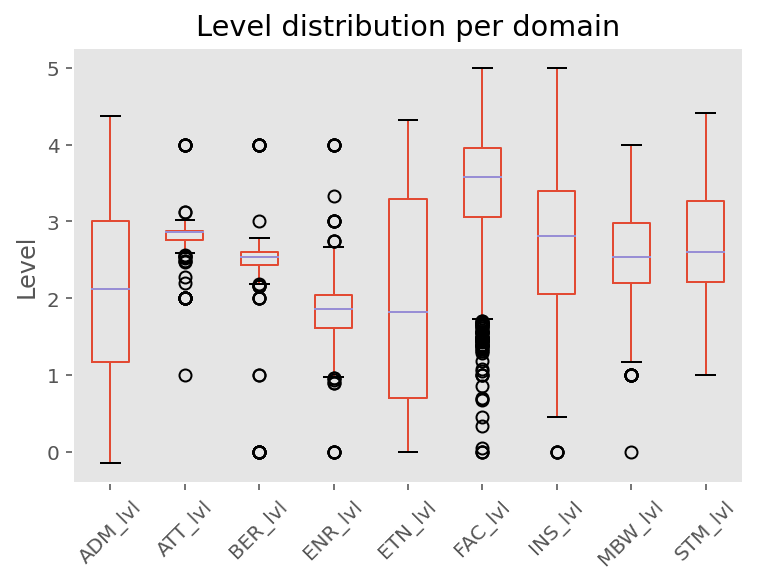

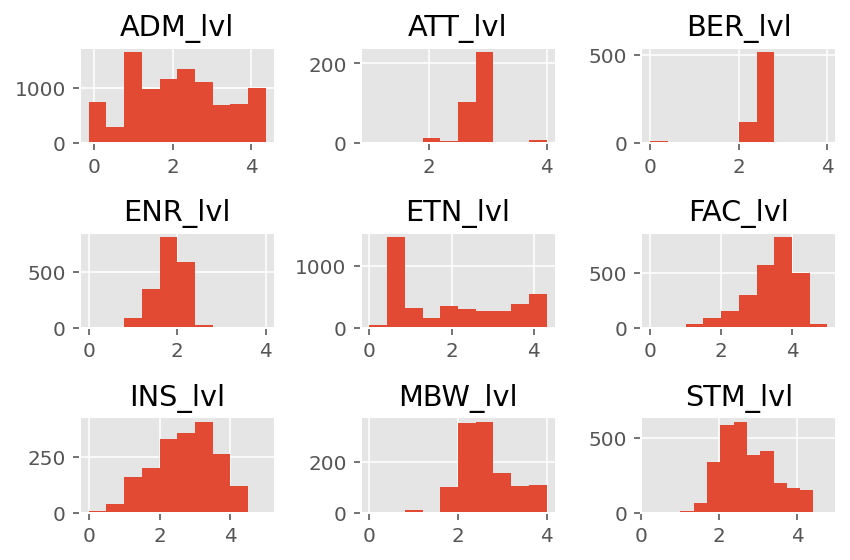

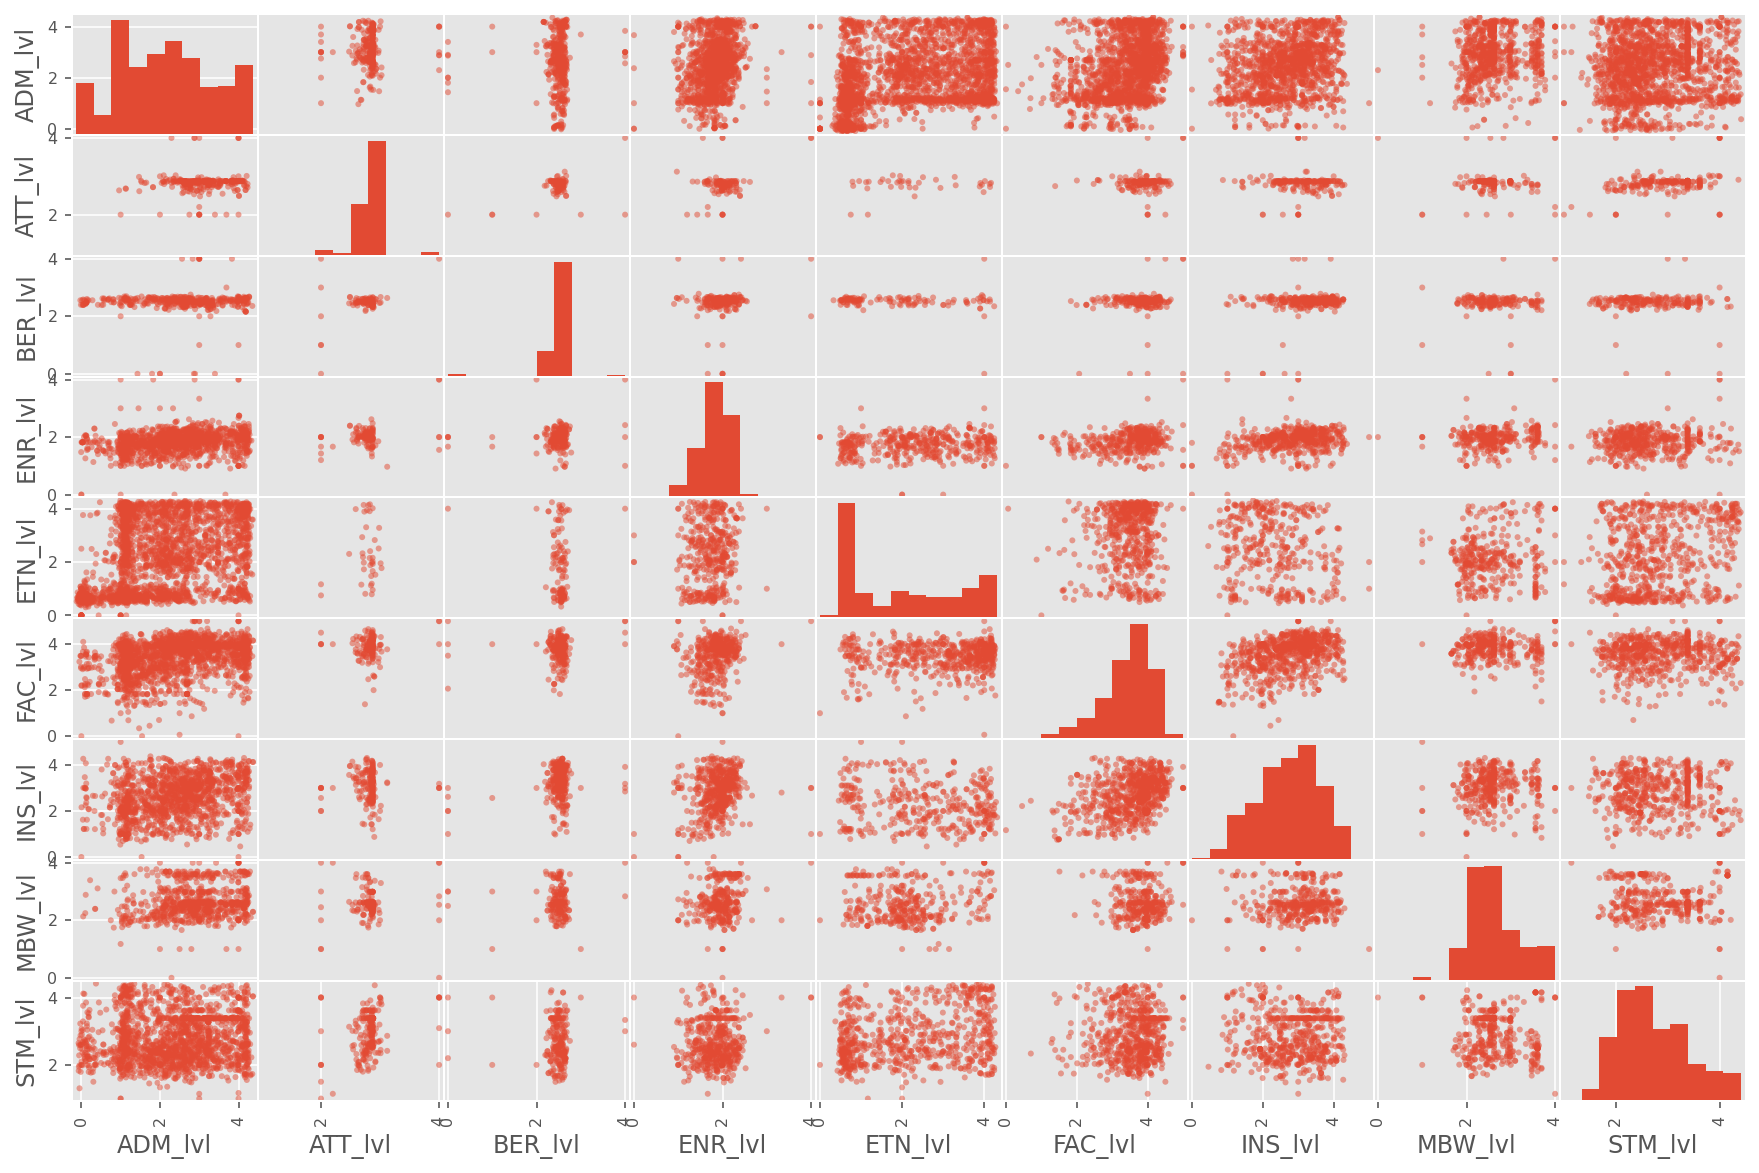

In [19]:
#distribution within admission period 
lev_distribution(discharge)
plt.show()

In [20]:
#how many unique patients do we have notes after discharge?

print('overall unique patients with discharge info: ' + str(discharge['MDN'].nunique()))
print('n unique patients from discharge to 6w: ' + str(df_d_to_6w['MDN'].nunique()))
print('n unique patients from 6w discharge to 3m: ' + str(df_6w_to_3m['MDN'].nunique()))

overall unique patients with discharge info: 1222
n unique patients from discharge to 6w: 1222
n unique patients from 6w discharge to 3m: 941


## Histograms of frequency of notes over time

### Overall and per domain

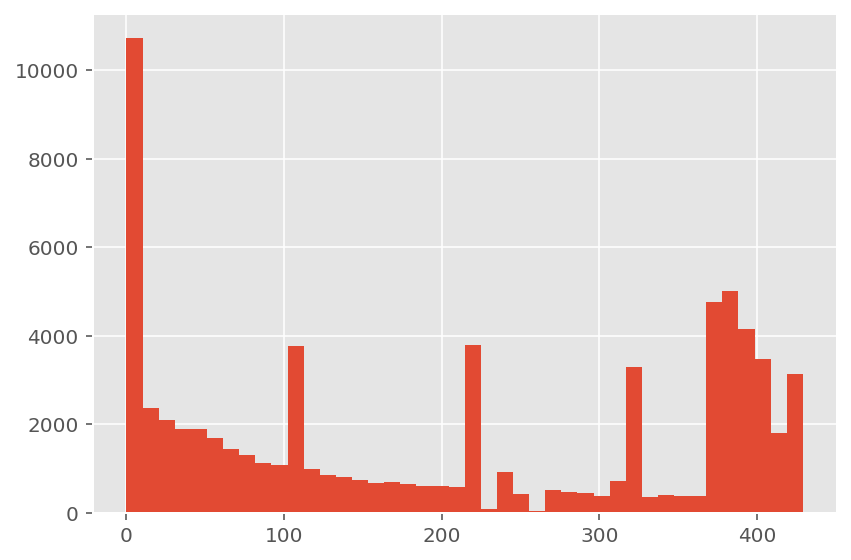

In [21]:
#overall frequency
df['Days_count'].hist(bins=42)
plt.tight_layout()
plt.savefig('./figures/frequency_day_histogram.png', dpi=300)

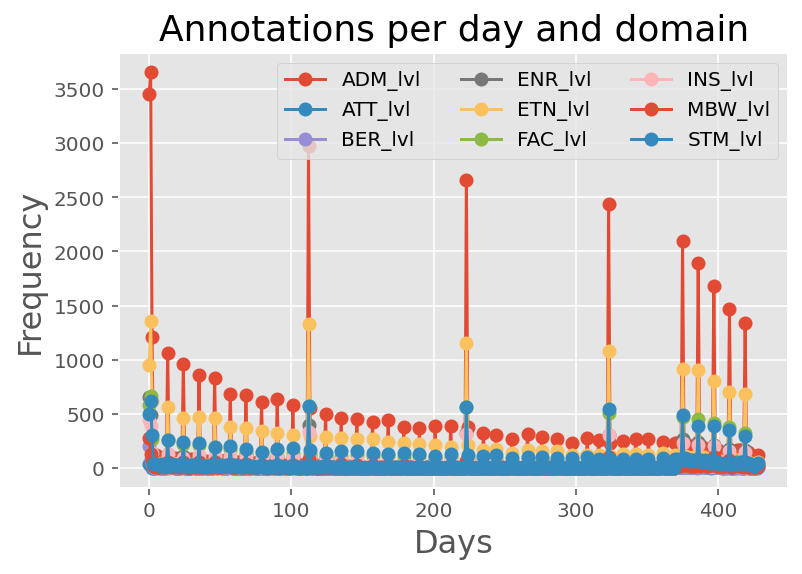

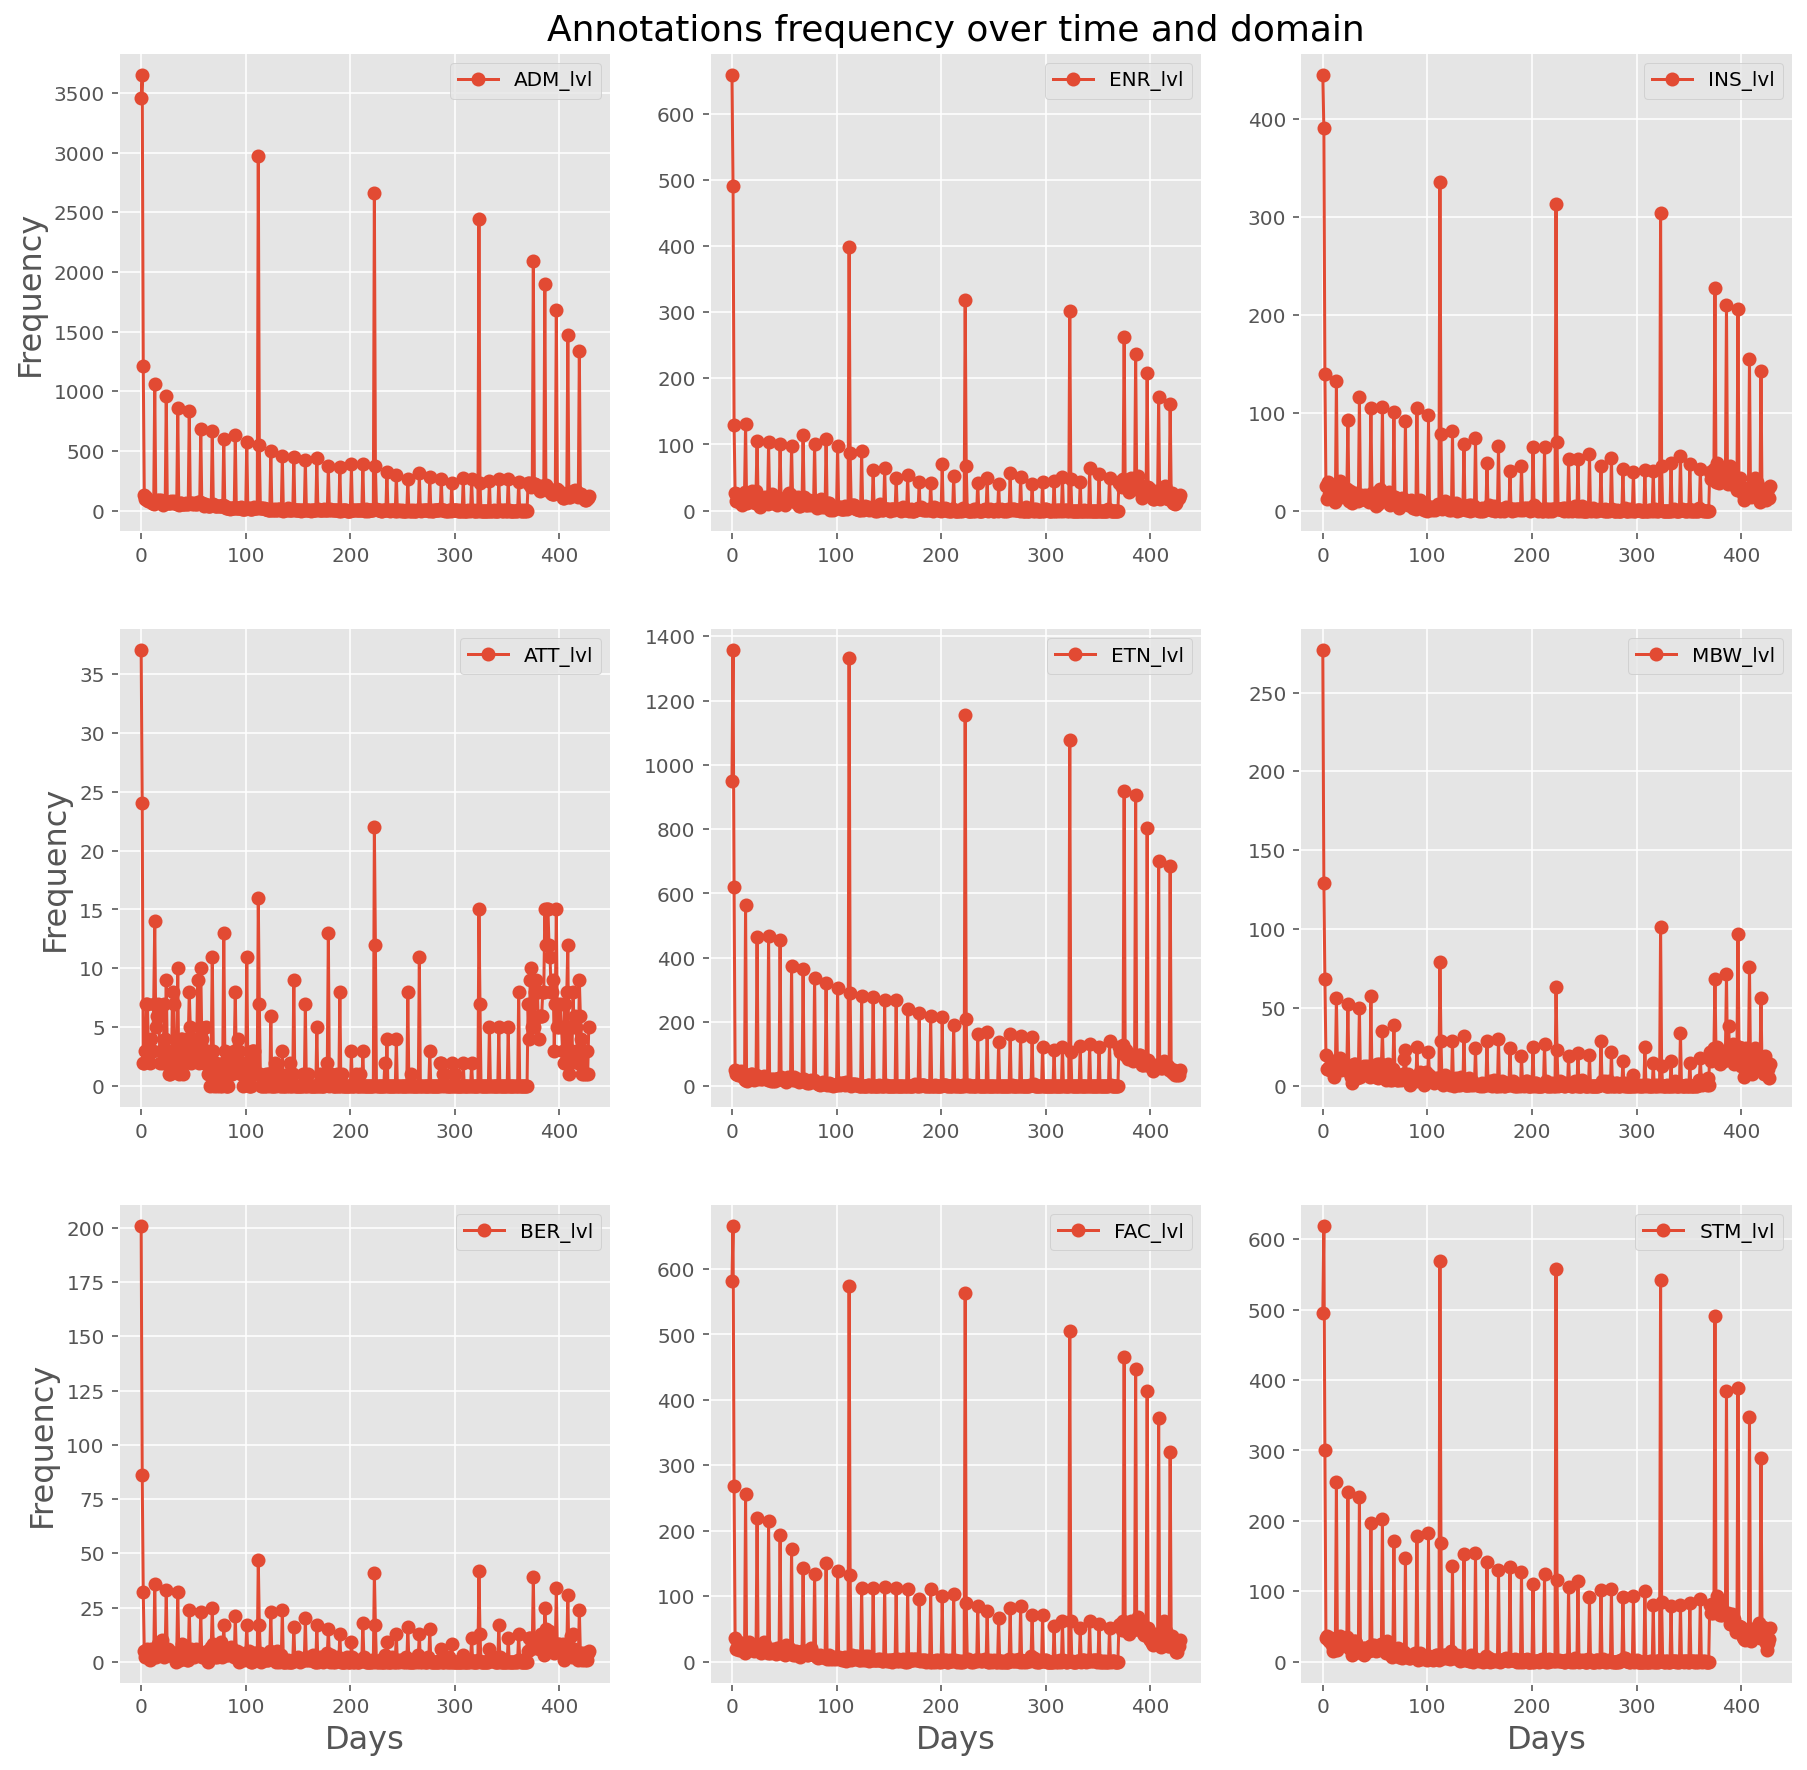

In [22]:
def freq_annot_per_domain(df):
     '''creates a dataframe made from filtered frequencies per domain.
     Plots frequency per domain in the same plot as well as separately.'''
     
     ADM_c =[]
     ATT_c =[]
     BER_c =[]
     ENR_c =[]
     ETN_c =[]
     FAC_c =[]
     INS_c =[]
     MBW_c =[]
     STM_c =[]

     for day in range(0,df['Days_count'].max()):
          subset_df = df[df['Days_count'] == day]
          ADM_c.append(subset_df.count()[6])
          ATT_c.append(subset_df.count()[7])
          BER_c.append(subset_df.count()[8])
          ENR_c.append(subset_df.count()[9])
          ETN_c.append(subset_df.count()[10])
          FAC_c.append(subset_df.count()[11])
          INS_c.append(subset_df.count()[12])
          MBW_c.append(subset_df.count()[13])
          STM_c.append(subset_df.count()[14])

     df = pd.DataFrame(np.array([ADM_c]).T)
     df.columns =['ADM_lvl']

     df['ATT_lvl'] = np.array([ATT_c]).T
     df['BER_lvl'] = np.array([BER_c]).T
     df['ENR_lvl'] = np.array([ENR_c]).T
     df['ETN_lvl'] = np.array([ETN_c]).T
     df['FAC_lvl'] = np.array([FAC_c]).T
     df['INS_lvl'] = np.array([INS_c]).T
     df['MBW_lvl'] = np.array([MBW_c]).T
     df['STM_lvl'] = np.array([STM_c]).T

     plt.plot(df, 'o-')
     plt.title("Annotations per day and domain",fontsize=18)
     plt.xlabel("Days",fontsize=16)
     plt.ylabel("Frequency",fontsize=16)
     plt.legend(columns,ncol=3, loc='upper right')
     plt.tick_params(axis='both', labelsize= 10)
     plt.savefig('./figures/freq_annot_day_and_domain_plot.png', dpi=300)
     
     f, axx = plt.subplots(3,3, figsize=(5*3, 5*3))
     for i in range(3):
          for j in range(3):
               l = i + 3*j
               axx[i,j].plot(df.iloc[:,l], 'o-', label=columns[l])
               axx[0,1].set_title("Annotations frequency over time and domain",fontsize=18)
               axx[2,j].set_xlabel("Days",fontsize=16)
               axx[i,0].set_ylabel("Frequency",fontsize=16)
               axx[i,j].legend()
               axx[i,j].tick_params(axis='both', labelsize= 10)

     plt.savefig('./figures/freq_annot_day_and_domain_separateplots.png', dpi=300)
     
     return df

df_domain = freq_annot_per_domain(df)

## Levels of patients over time per domain

### Aggregated mean levels of patients over time per domain


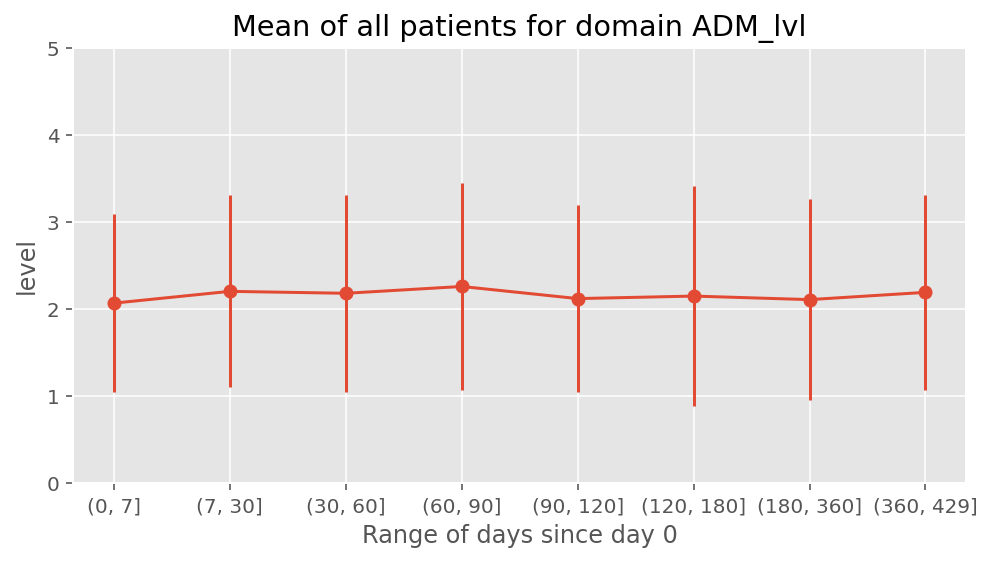

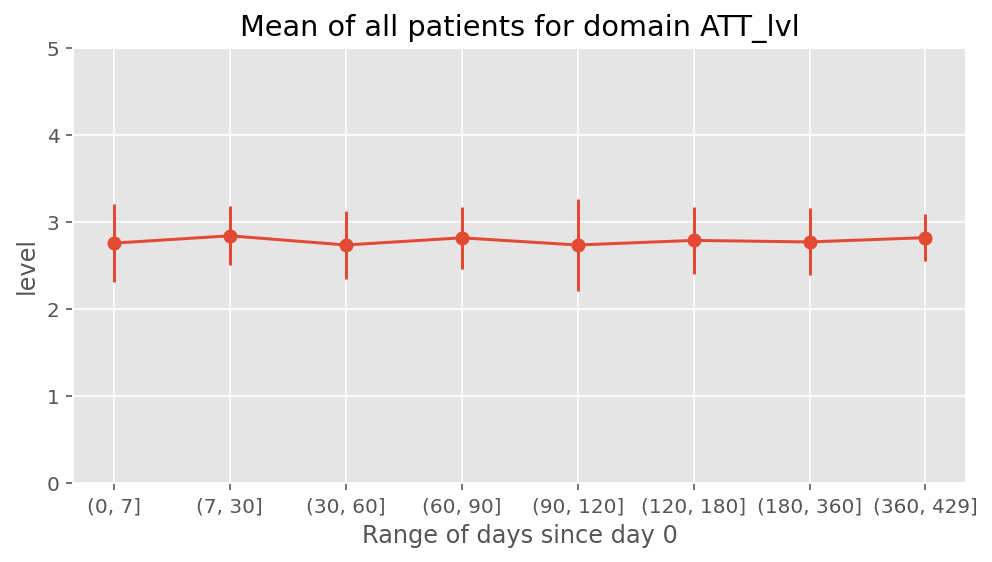

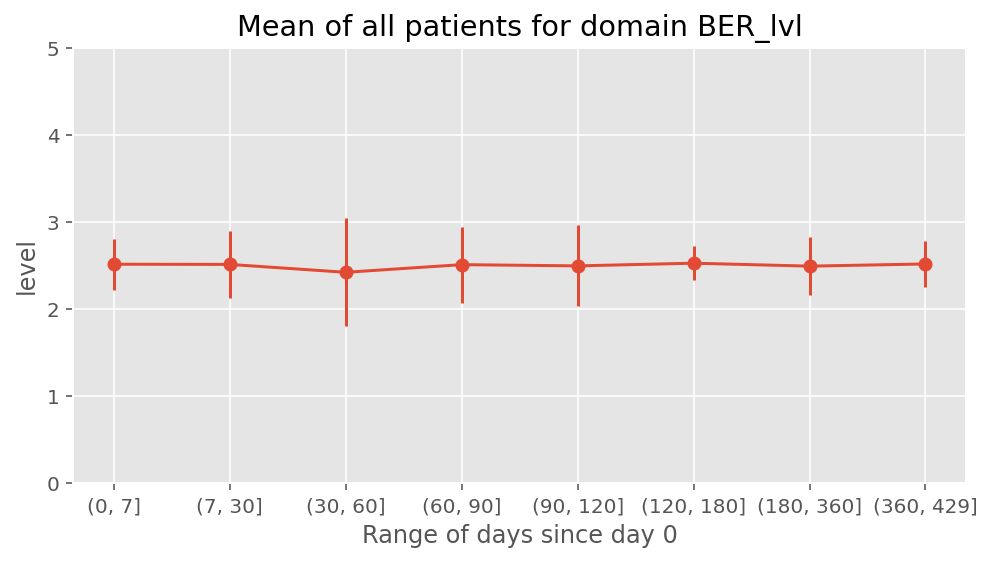

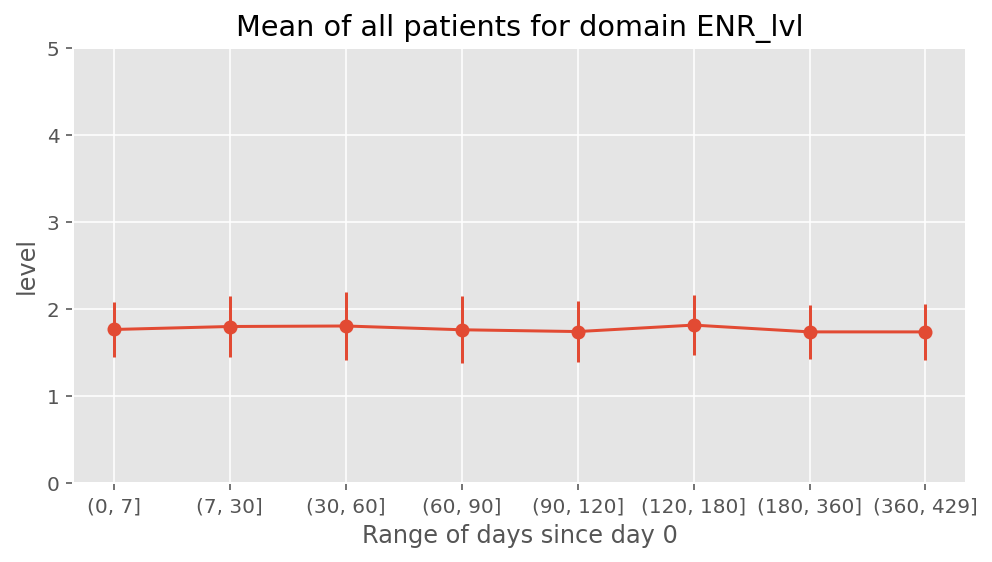

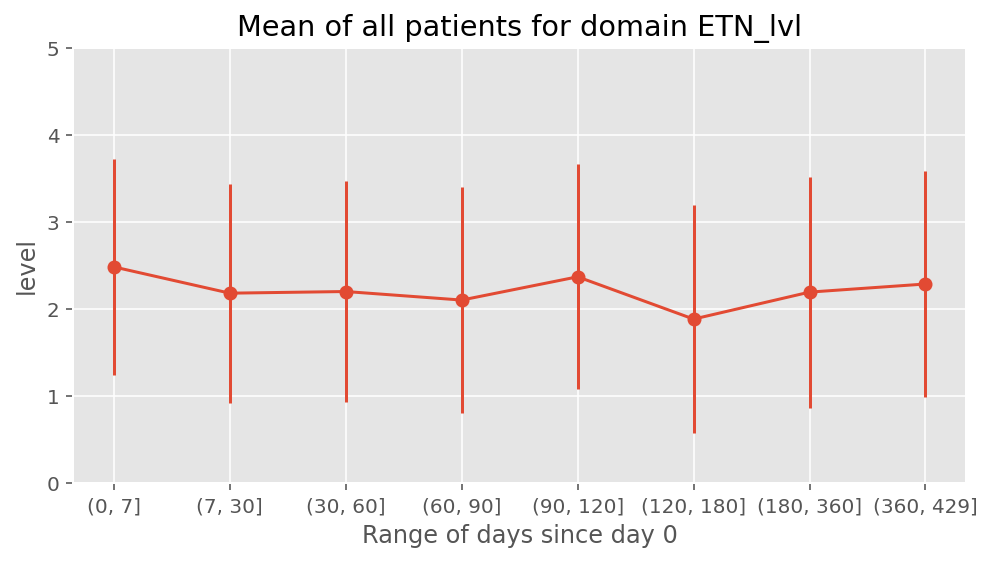

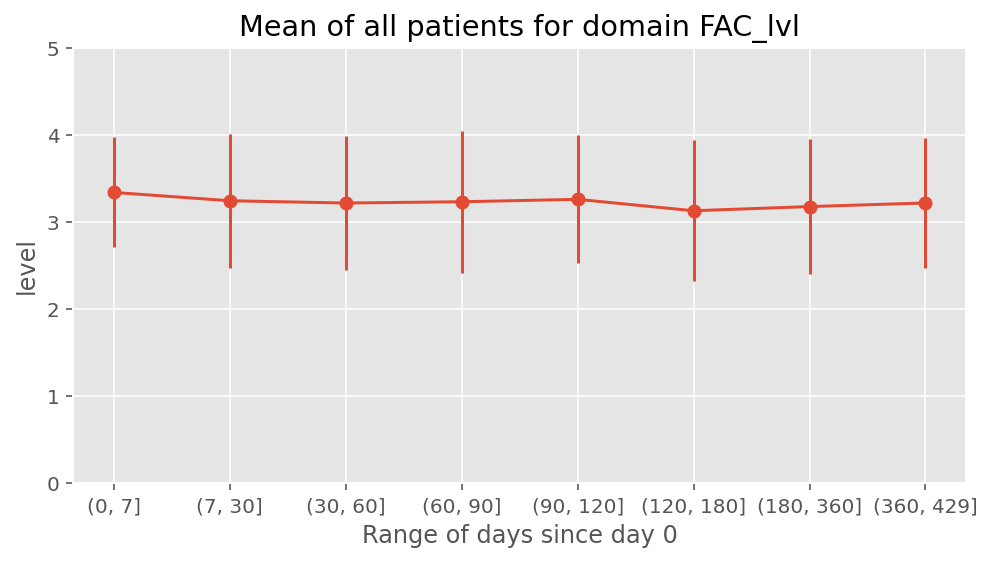

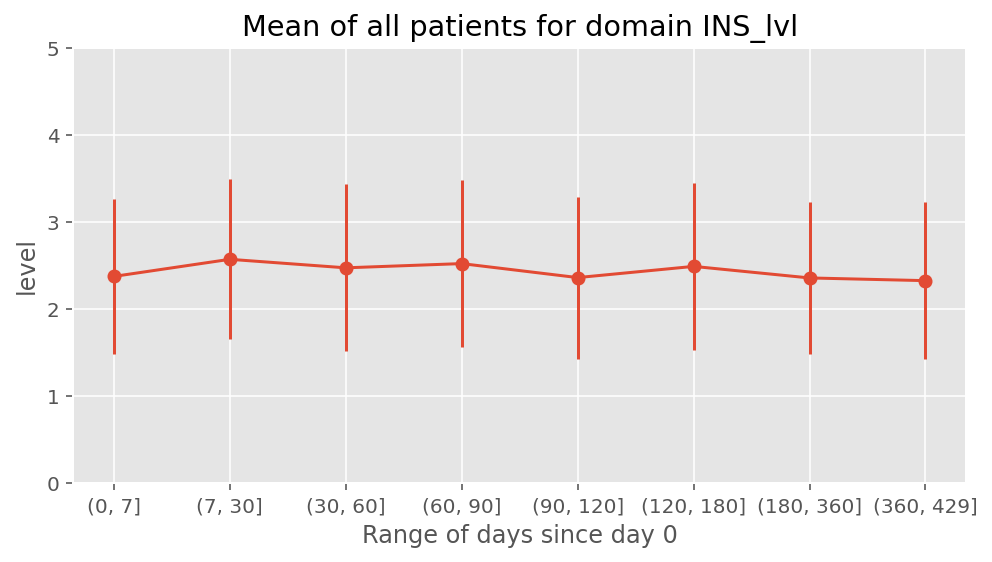

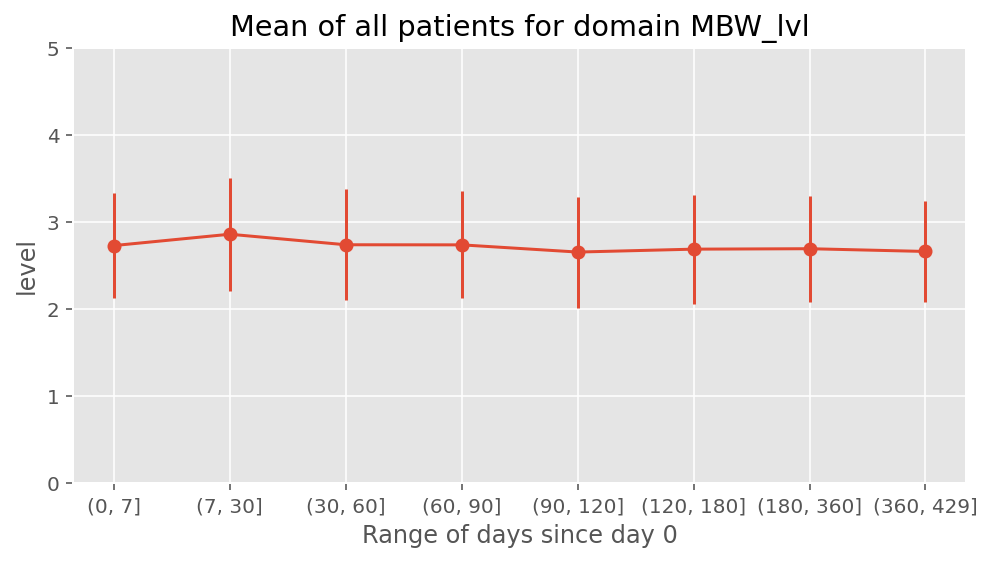

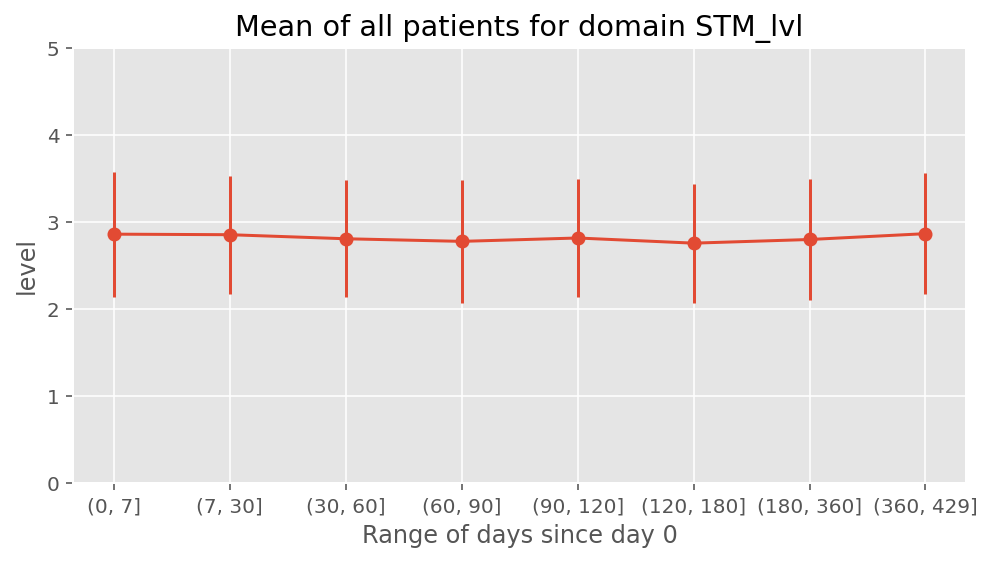

In [23]:
def mean_patients_dom_time(df):    
    '''Plots mean and std for a given dataframe per patient over time grouping data into bins.'''
    columns = ['ADM_lvl','ATT_lvl','BER_lvl','ENR_lvl','ETN_lvl', 'FAC_lvl','INS_lvl','MBW_lvl','STM_lvl']
    
    tmp = df.groupby(['Days_count', 'MDN']).median()[columns].reset_index()
    tmp = tmp.groupby(pd.cut(tmp.Days_count, [0, 7, 30, 60, 90, 120, 180, 360, 429])).agg({column: ['mean', 'std'] for column in columns})

    for column in columns:
        tmp[(column, 'mean')].plot(marker='o', yerr=tmp[(column, 'std')], ylim=(0,5), figsize=(8, 4))    
        plt.title(f'Mean of all patients for domain {column}')
        plt.ylabel('level')
        plt.xlabel('Range of days since day 0')
        plt.show()
    
overall = mean_patients_dom_time(df)

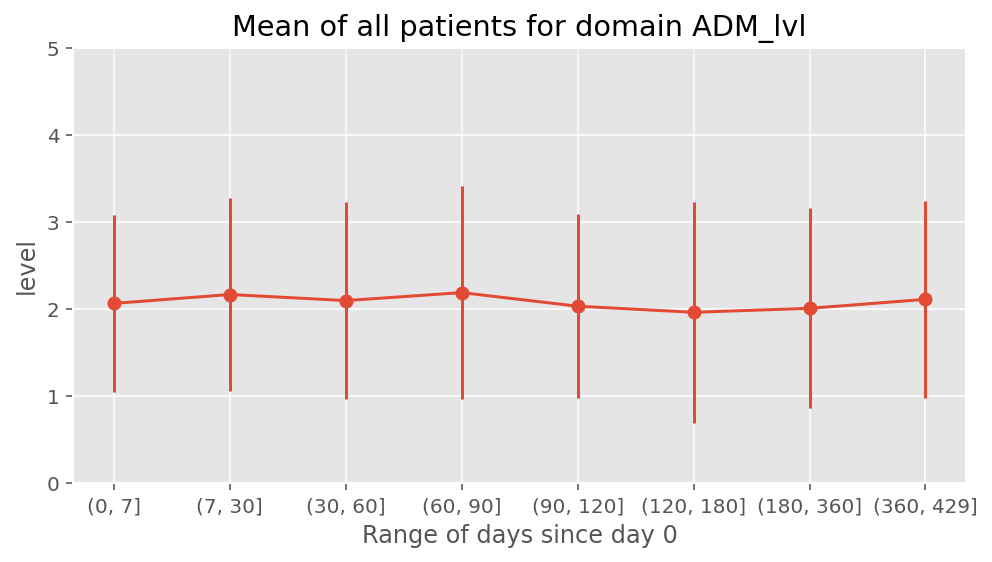

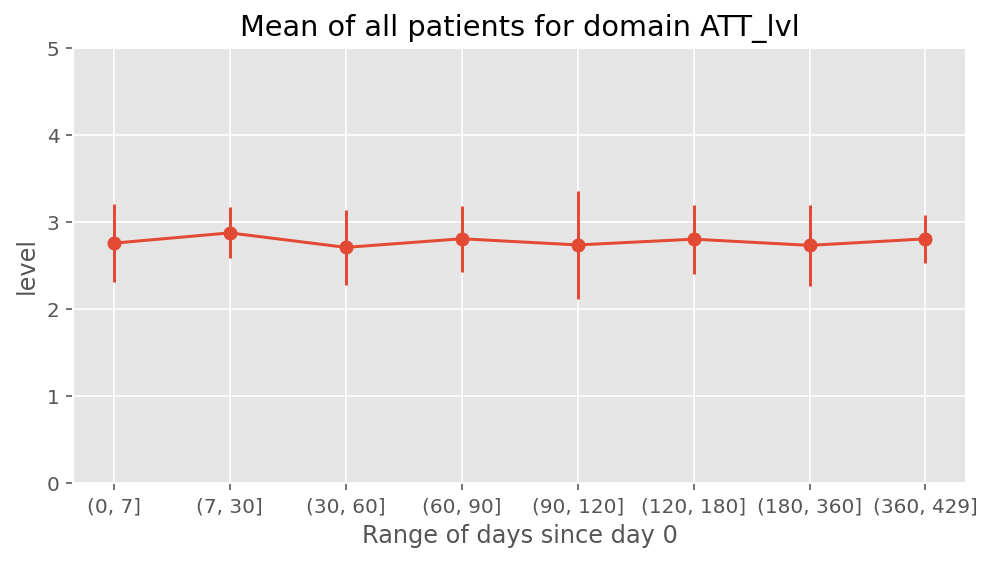

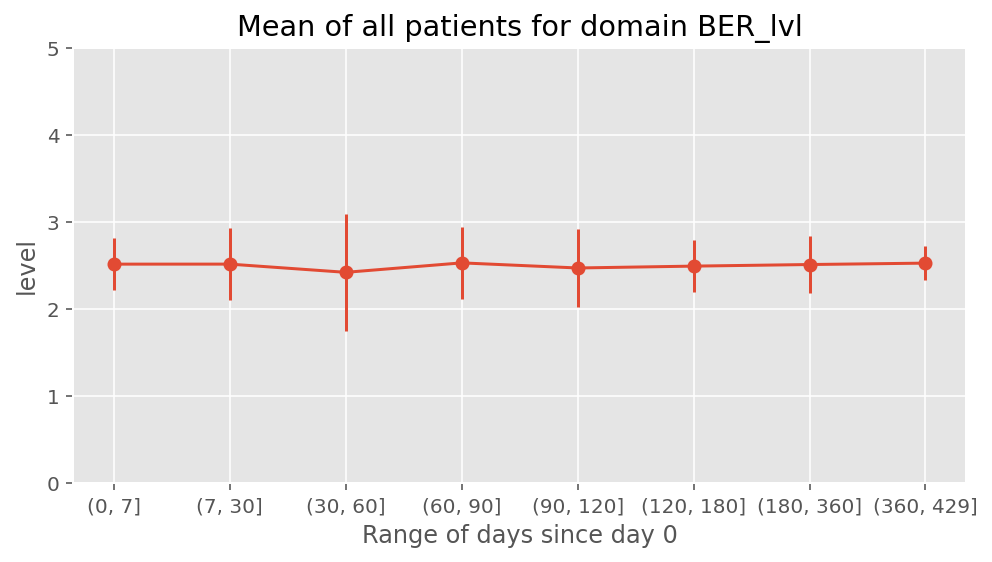

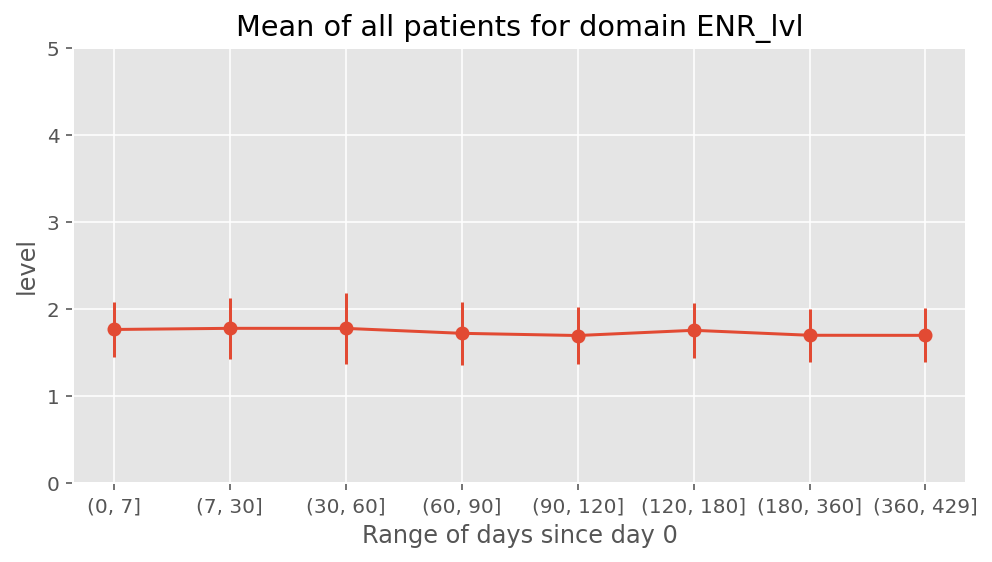

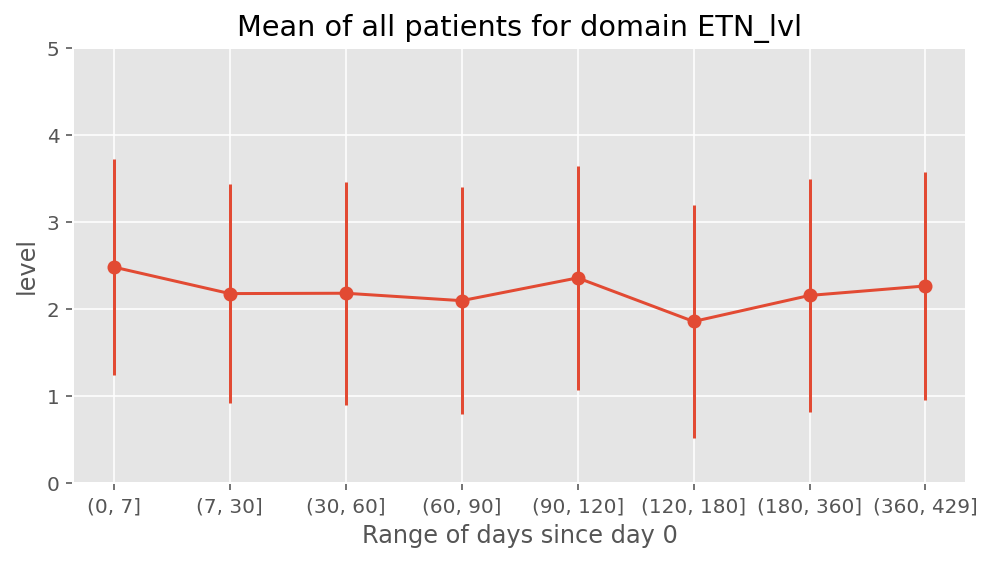

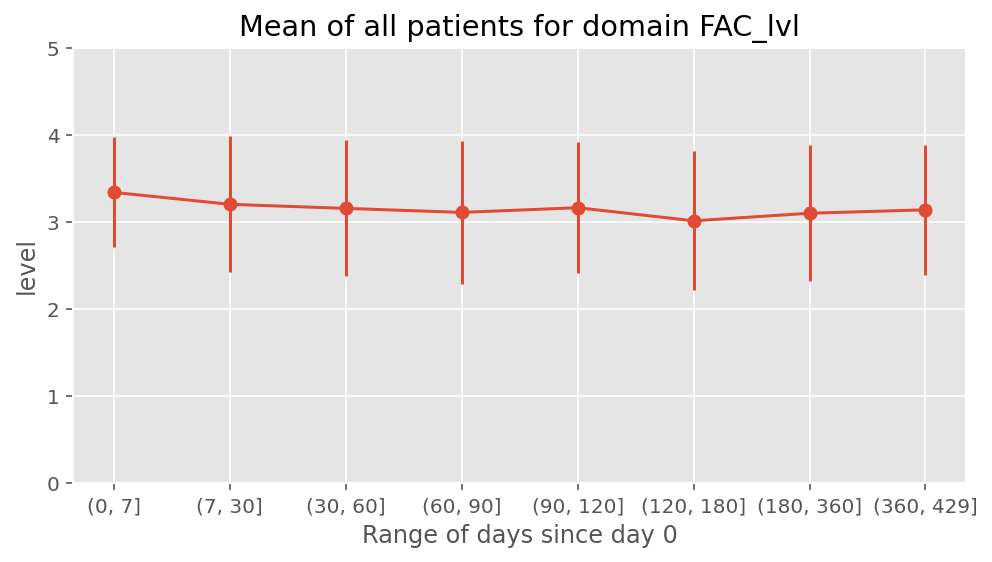

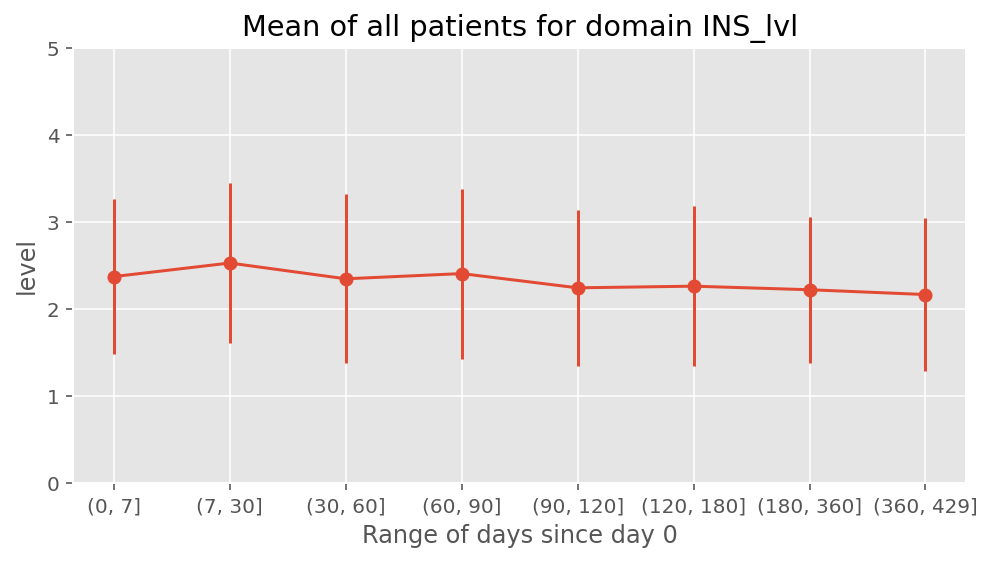

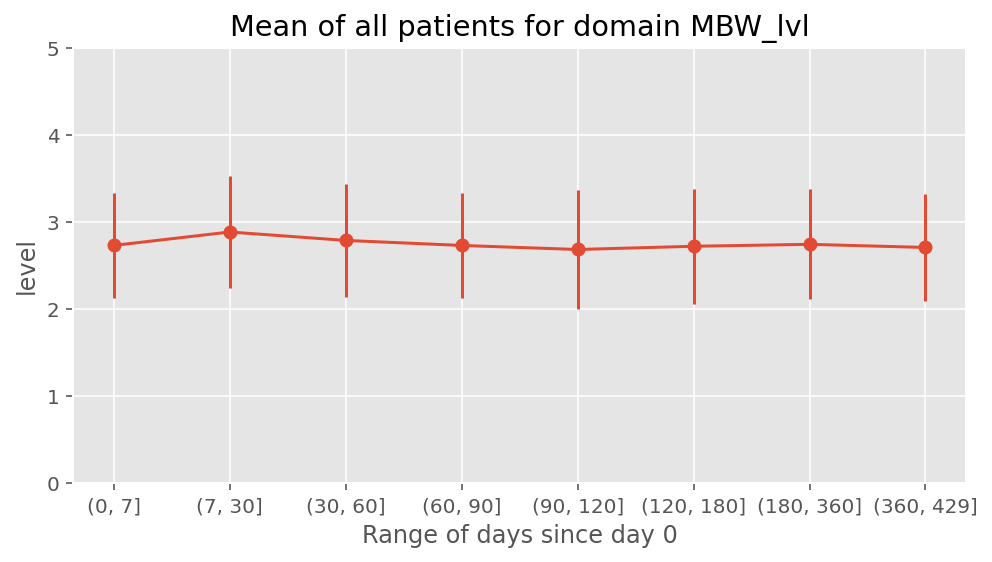

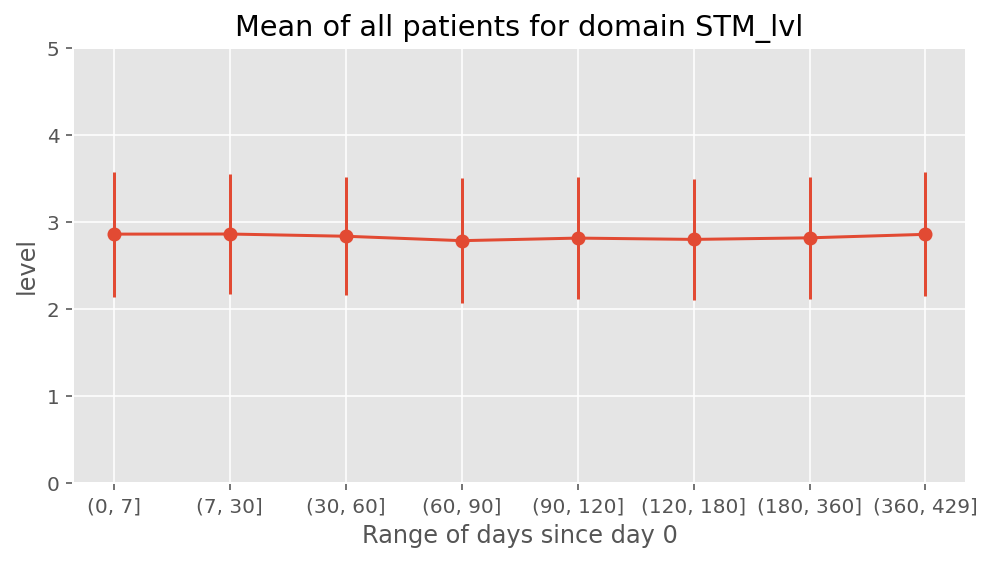

In [24]:
admission_time = mean_patients_dom_time(df_trim)

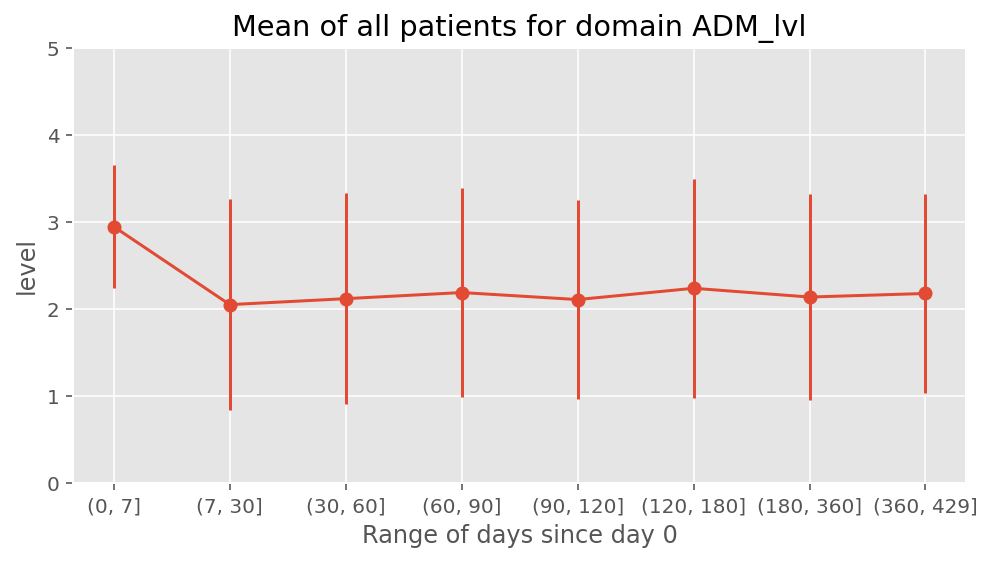

/Users/brunaguedes/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


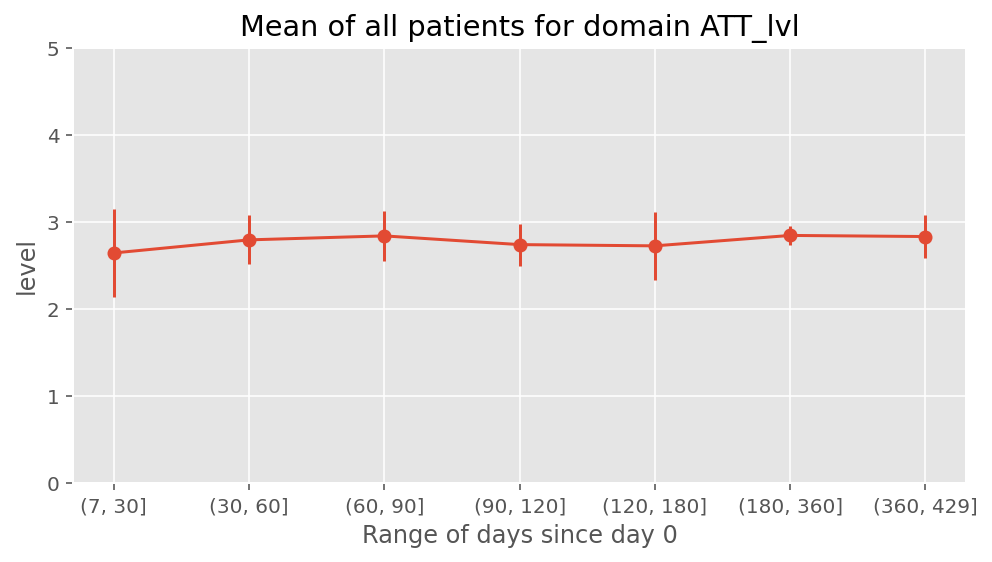

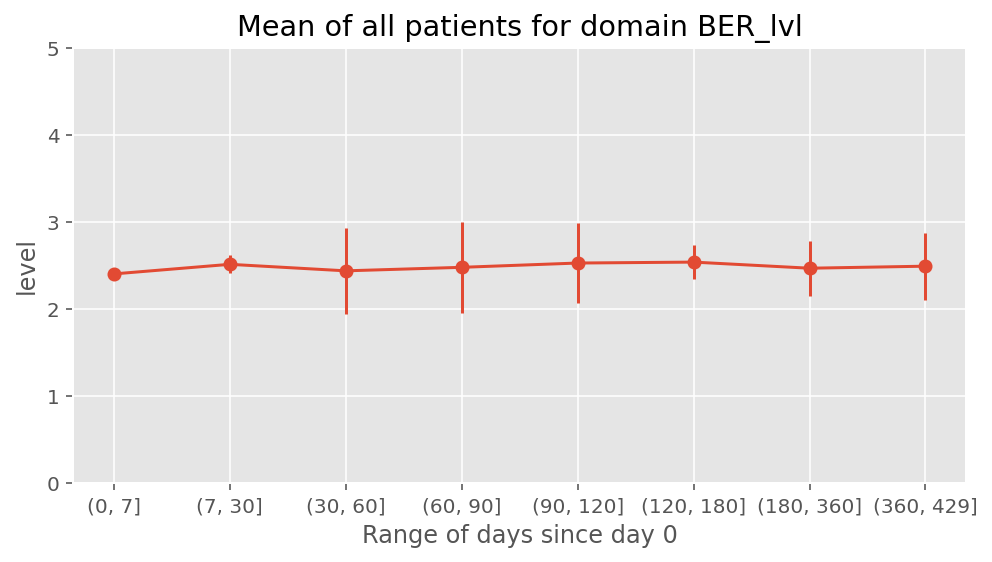

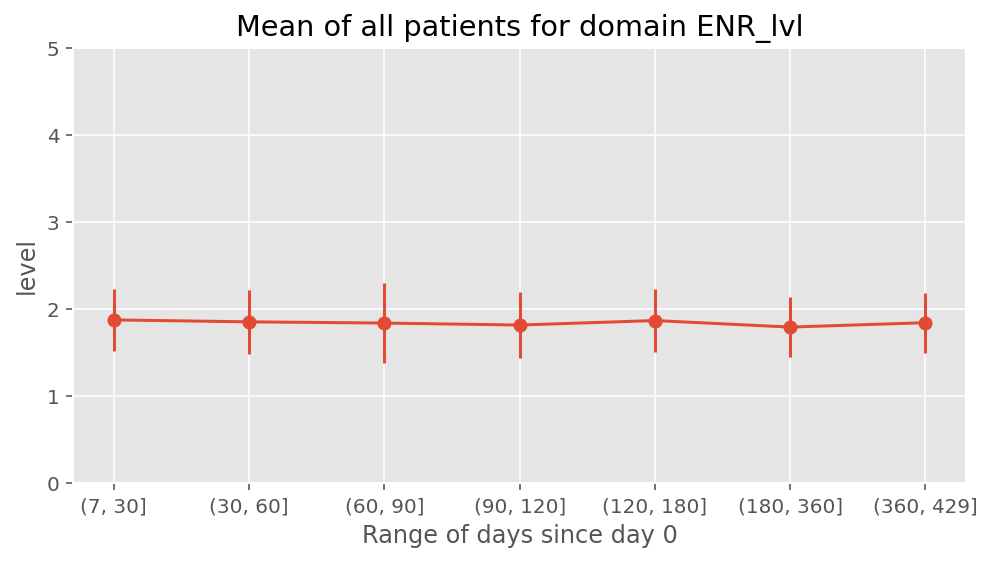

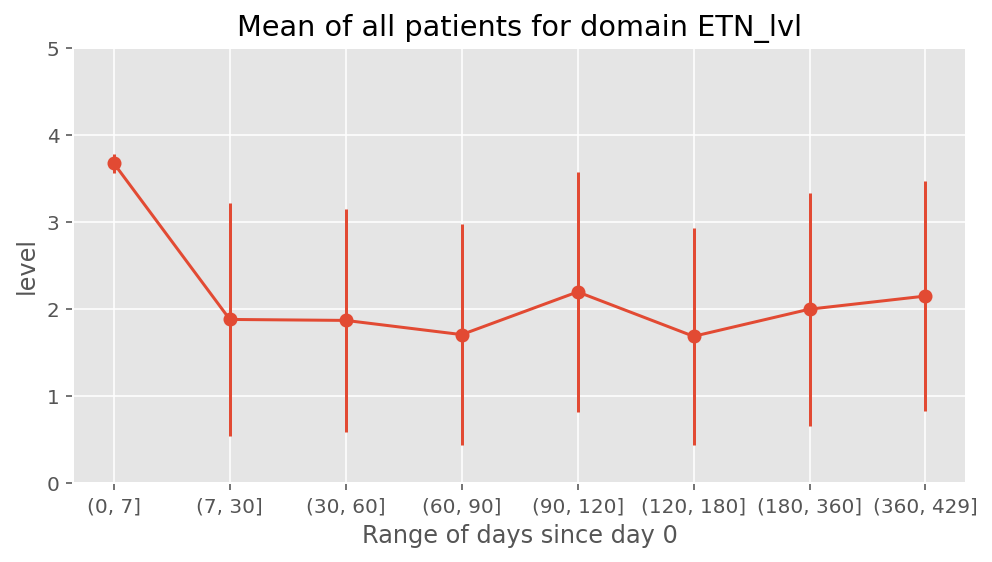

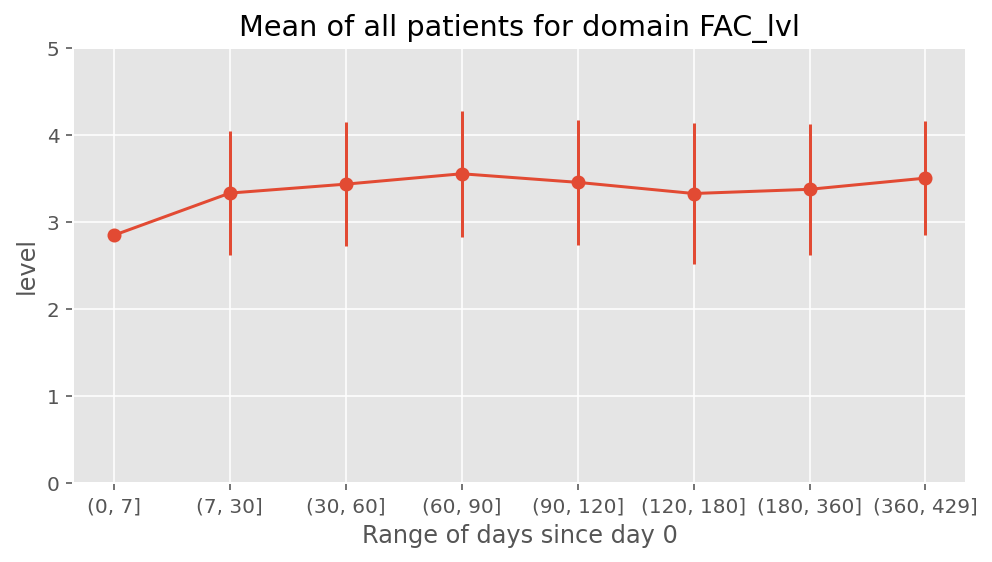

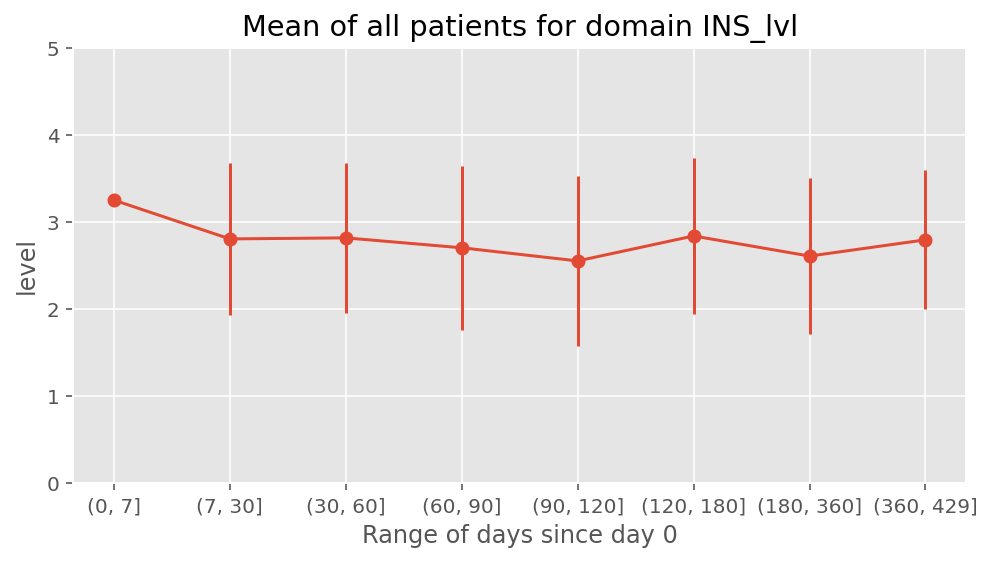

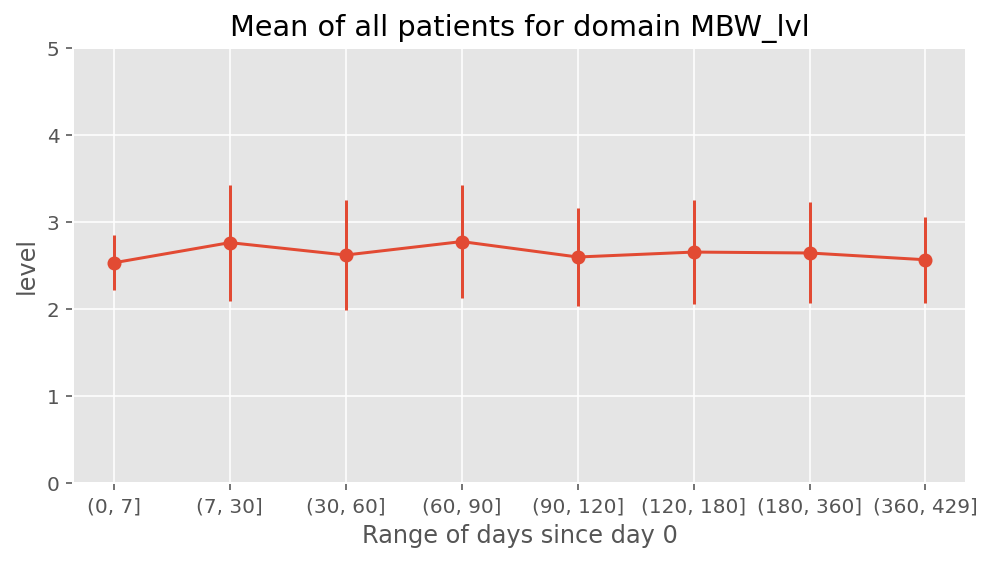

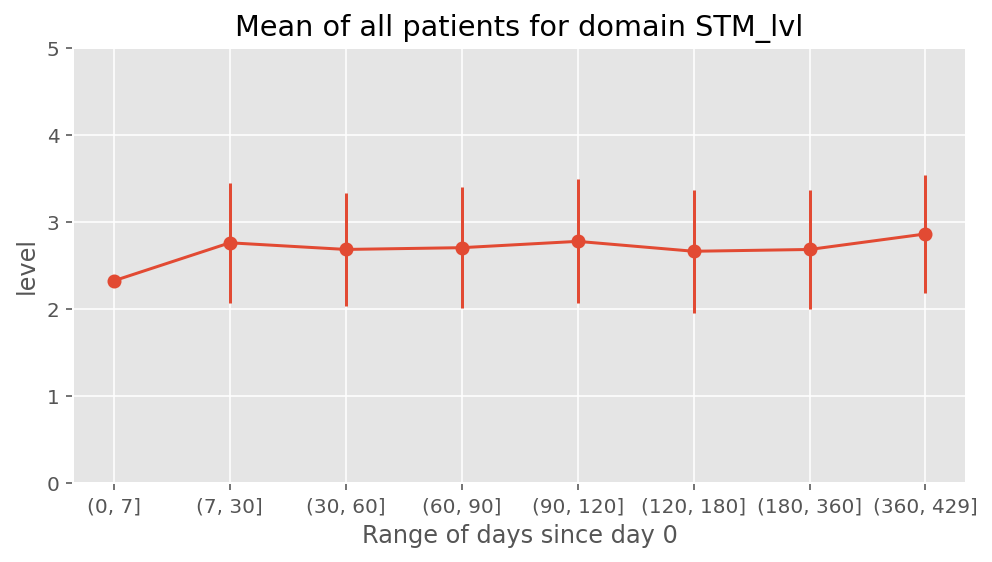

In [25]:
discharge_time = mean_patients_dom_time(discharge)

### Individual levels of patients over time per domain

Disclaimer: high number of patients can lead to extensive number of plots -> one plot per patient

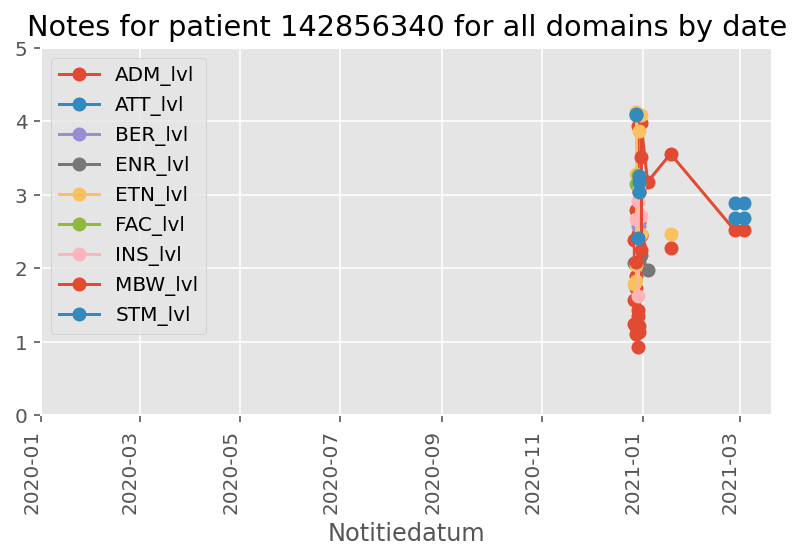

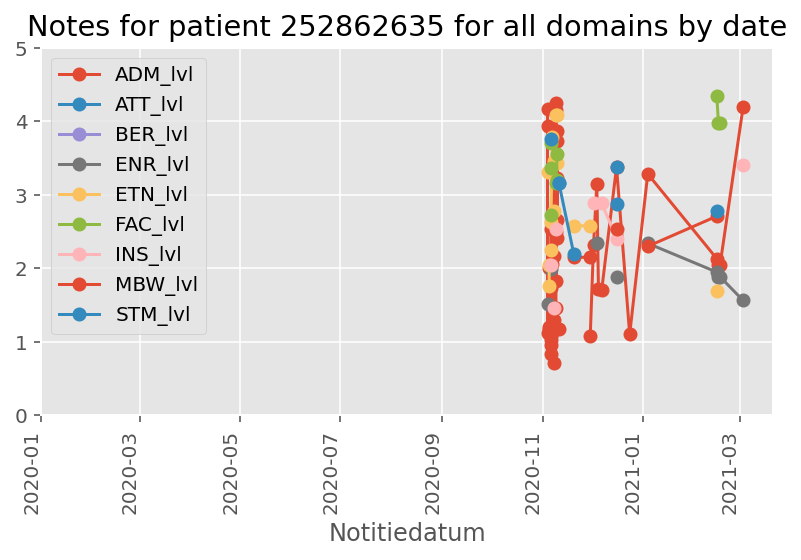

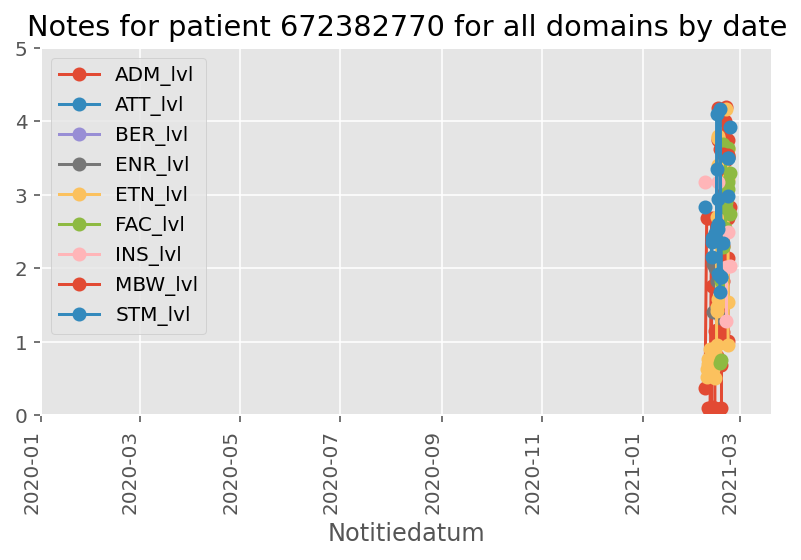

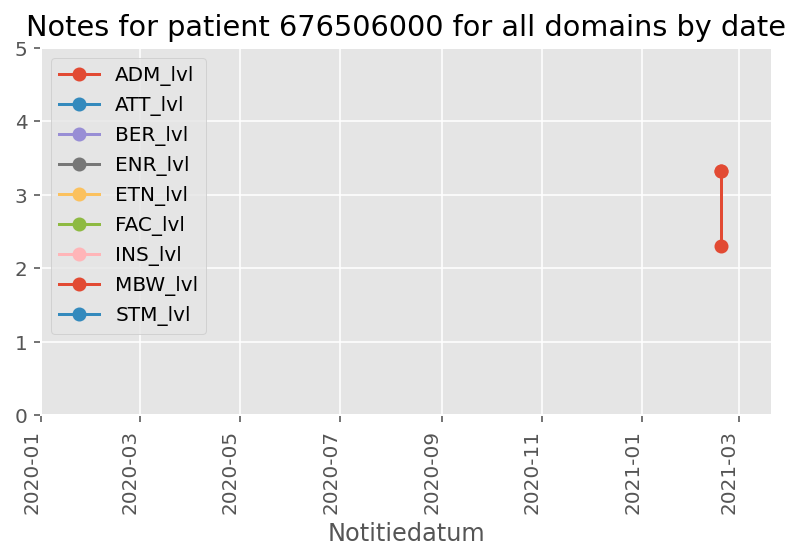

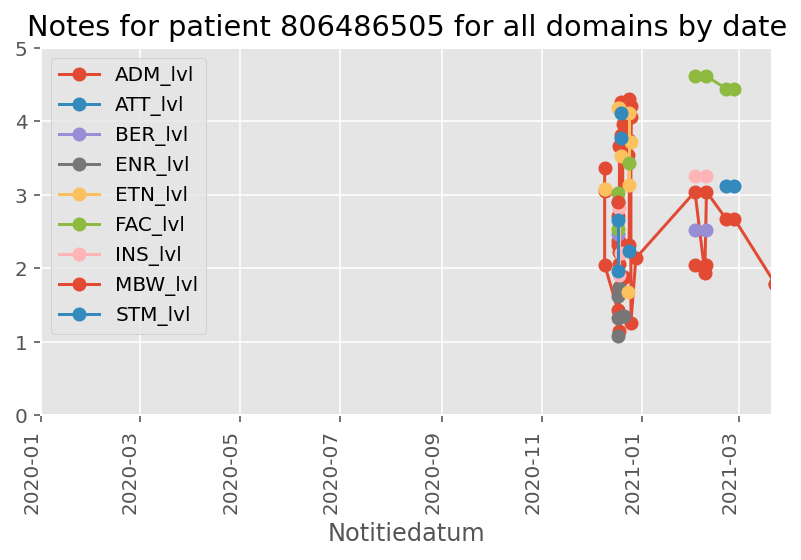

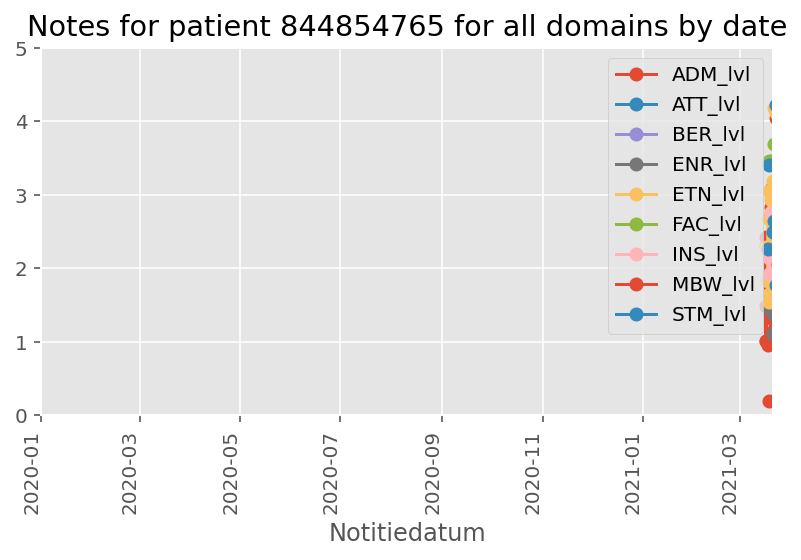

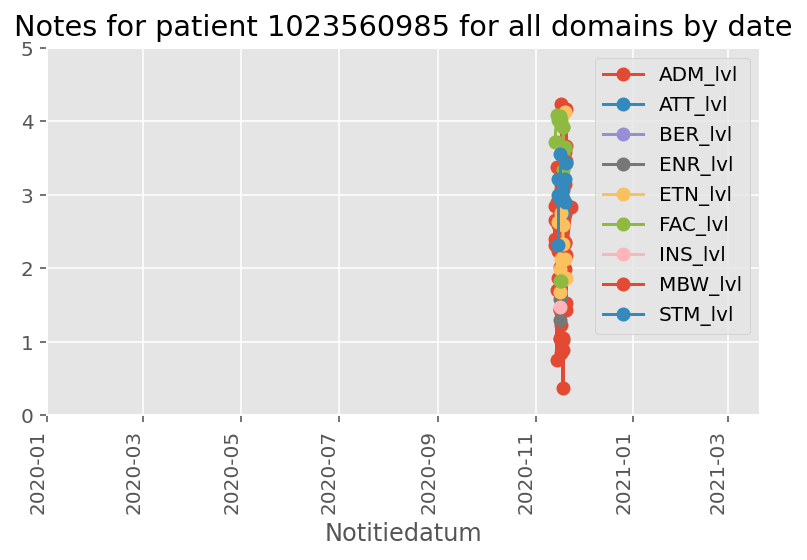

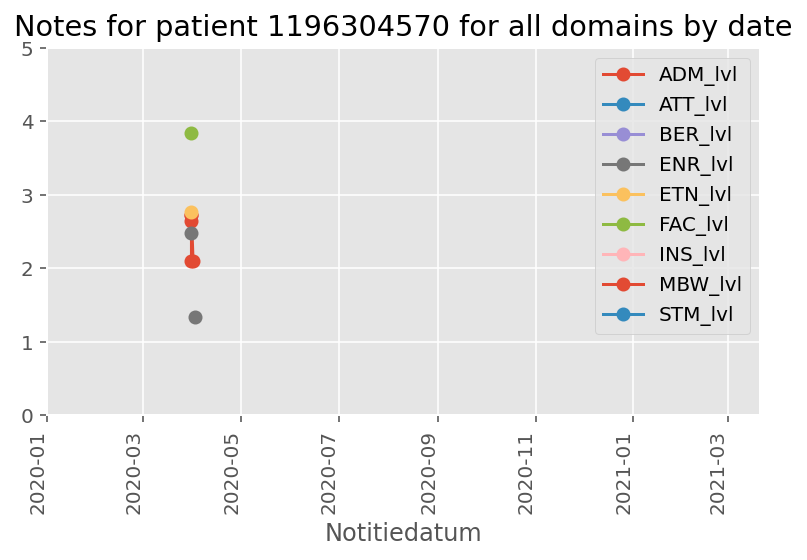

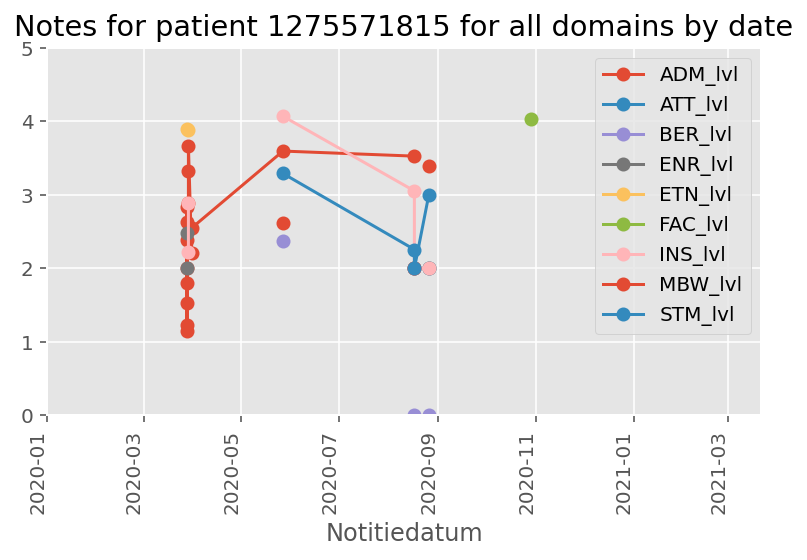

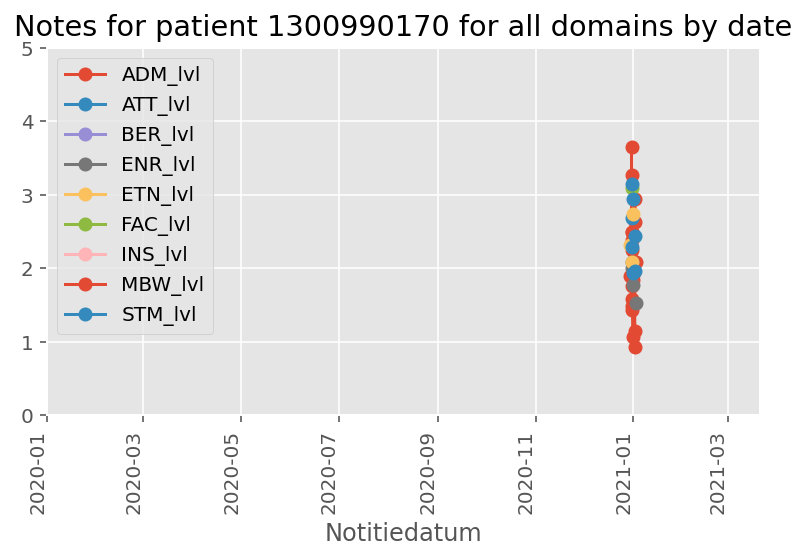

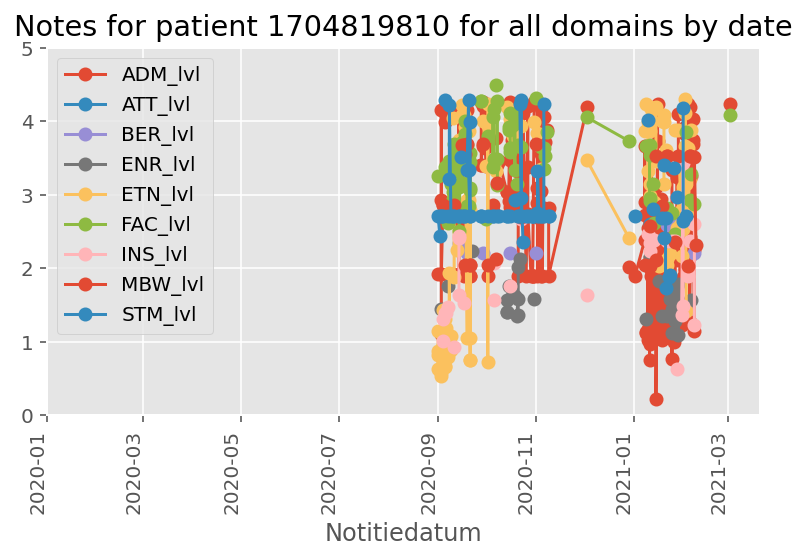

KeyboardInterrupt: 

In [26]:
for i in df.MDN.unique():
    data =  df[ df.MDN == i].sort_values(by='Notitiedatum', ascending=True)
    data['Notitiedatum'] = pd.to_datetime(data['Notitiedatum'])
    data.plot(kind='line', x='Notitiedatum', y=columns, marker='o', rot=90)
    #if we want to see with more detail comment xlim
    plt.xlim([datetime.date(2020, 1, 1), datetime.date(2021, 3, 21)]) 
    plt.ylim(0, 5)
    plt.title(f"Notes for patient {i} for all domains by date")
    plt.tight_layout()
    plt.show()